# Data

In [1]:
import csv
import datetime
import glob
import itertools
import contextlib

import pickle
import scipy.sparse
import time
import zipfile 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter

sns.set_style('whitegrid')
sns.set_palette('pastel')
sns.set_context('poster')
#sns.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')

import random

random.seed(16)


# Initial code found in https://github.com/eleijonmarck/DDSC/blob/master/src/dsc/dsc.py

## **Import data: REFIT & REDD**

In [2]:
with open('refit_redd_2nd_attempt.pk', 'rb') as f:
    data = pickle.load(f)

train, test = data['train'], data['test']

In [3]:
train = [train]
test = [test]

In [4]:
from __future__ import division
import numpy as np
import pandas as pd
import time
#import librosa
import pickle
from sklearn.decomposition import SparseCoder,DictionaryLearning, sparse_encode
from sklearn.model_selection import GridSearchCV
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

import matplotlib.pyplot as plt
import itertools


class DSC():
    def __init__(self, X, general_params, nnsc_params, dd_params, transfer_params=None):
        """
        Args:
            The args are "X, m, T, general_params, nnsc_params, dd_params"
            
            X: training data - List
            #m: number of rows - int
            #T: number of columns (houses) - int
            
            general_params - Dict:
                weeks_to_train - int: number of subsets of data to use, by weekly subset
                rp - float: regularization parameter for SC (and DD) training (sparsity penalty)
                max_iter - int: maximum iter for the SparseCoder function in the Objective function F_obj

            nnsc_params - Dict:
                gradient_step_size (mu) - float: gradient step size for SC
                steps - int: steps for SC training
                epsilon - float: tolerance level for SC training
                n - int: number of hidden components
                
            dd_params - Dict:
                dd_mu - float: gradient step size for DD
                dd_steps - int: steps for DD training
                dd_epsilon - float: tolerance level for DD training
            
            
        """
        self.X = X
        
        self.weeks_to_train = general_params['weeks_to_train']
        self.rp = general_params['rp']
        self.max_iter = general_params['max_iter']
        
        
        self.mu = nnsc_params['gradient_step_size']
        self.steps = nnsc_params['steps']
        self.epsilon = nnsc_params['epsilon']
        self.n = nnsc_params['n_components']
        
        #self.m = m
        #self.T = T
        
        self.dd_steps = dd_params['dd_steps']
        self.dd_epsilon = dd_params['dd_epsilon']
        self.dd_mu = dd_params['dd_mu']

        if transfer_params:
          self.a = transfer_params['a']
          self.b = transfer_params['b']


################################################################
# will initiualize the matrices A,B with positive values and scale
# columns of B s.t b(j) = 1
    def _initialization(self):
      
        a = np.random.random((self.n,self.m))
        b = np.random.random((self.T,self.n))

        # scale columns s.t. b_i^(j) = 1
        b /= sum(b)
        return a,b

    def nnsc_obj_error(self,x, Ap, Bp):
      #print('Ap', Ap)
      #print(np.dot(Bp, Ap))
      return np.linalg.norm(np.dot(Bp, Ap)-x, 2)

    def pre_training(self,x,enable_transfer_learning=False,coral=False):
        # TODO : implement s.t. conditions and frobenius norm to the options
        tic = time.time()
        #the NON NEGATIVE SPARSE CODING (or TSC)
        Ap, Bp ,errors = self.nnsc(enable_transfer_learning,coral)

        tac = time.time()
        t = tac - tic
        print('time of computations for Dictionary Learning with m: {} and T: {} took: {}'.format(self.m,self.T,t))
        return Ap, Bp ,errors
################################################################
    # using only the positive values, this is used for projected gradient descent
    @staticmethod
    def _constraint_for_basis_matrix(a):
        indices = np.where(a < 0.0)
        a[indices] = 0.0
        return a
#################################################################
    def nnsc(self, enable_transfer_learning, coral=False):
        '''
        Method as in NNSC from nonnegative sparse coding from P.Hoyer
        TODO:
        Also create multiple ndarrays that we take the argmin for.
        '''
        errors = []
        # used for F
        A_list = []
        B_list = []
        for ind in range(self.weeks_to_train):

            one_X = self.X.copy()[ind].values
            self.T, self.m = one_X.shape
            Ap, Bp = self._initialization()
            Ap1 = Ap
            Bp1 = Bp
            t = 0
            sparse_matrix_variation = 1

            target_ind = ['target' in x for x in train[0]['X_bar']].index(True)
            if enable_transfer_learning:# or True:
              # Initialize MMD and GL matrices
              S = np.zeros((self.m, self.m))
              N_s, N_t = target_ind, self.m - target_ind
              S[: target_ind, :target_ind] = 1/N_s**2
              S[target_ind:, target_ind:] = 1/N_t**2
              S[target_ind:, :target_ind] = -1/(N_s*N_t)
              S[: target_ind, target_ind:] = -1/(N_s*N_t)
              #print('S', S)
              K = kneighbors_graph(one_X.T, n_neighbors=3).todense()
              L = np.diag(np.sum(K, axis=1))
              #U = K - L
              # Dunno why the line above the one above doesn't work well, so I'm gonna fix it
              L = np.sum(K, axis=1)
              U = K
              for i in range(U.shape[0]):
                U[i, i] = U[i, i] - L[i]

              S_tilde = self.a * S + self.b * U
              S_tilde[S_tilde<0] = 0    # I'm unsure about this

            # algo for NNSC

            err_iter = []
            #print('iniA', Ap)

            # CORAL BLOCK
            if coral:  # https://arxiv.org/pdf/1612.01939.pdf
              print("Applying Correlation Alignment to Basis matrices")
              print('shapes', one_X[:,target_ind:].shape, one_X.shape)
              cor_transformer = CORAL(Xt=one_X[:,target_ind:].T, random_state=0, lambda_=0.01)
              one_X_coral = cor_transformer.fit_transform(one_X[:,:target_ind].T, one_X[:,target_ind:].T)
              # remove positivity
              one_X_coral[one_X_coral < 0] = 0
              print('original', one_X, 'aa', np.median(one_X), np.max(one_X))
              aa = one_X_coral*(np.max(one_X) / np.max(one_X_coral))
              one_X[:,:target_ind] = one_X_coral.T
              print('coral', one_X.shape, one_X_coral.shape, one_X_coral.min(), '\n', aa, np.median(aa), np.max(aa))


            while t <= self.steps and self.epsilon <= sparse_matrix_variation:
                # 2a
                Bp = Bp - self.mu*np.dot((np.dot(Bp,Ap) - one_X),Ap.T)
                # 2b
                Bp = self._constraint_for_basis_matrix(Bp)
                # 2c
                Bp /= sum(Bp)
                # element wise division
                if not enable_transfer_learning: #SC, no transfer
                  dot2 = np.divide(np.dot(Bp.T,one_X),(np.dot(np.dot(Bp.T,Bp),Ap) + self.rp))
                  # 2d
                  Ap = np.multiply(Ap,dot2)
                else: #TSC, transfer using MMD and GL
                  transfer_update = np.dot(Ap, (S_tilde + S_tilde.T)) #Check this

                  if t % (self.steps // 5) == 0:
                    print('\n norms:', np.linalg.norm(transfer_update), np.linalg.norm(Ap), 'rapport ', np.linalg.norm(transfer_update)/np.linalg.norm(Ap))
                    print('MMD term ', np.trace(np.dot(Ap, np.dot(S_tilde, Ap.T))), '\n')

                  dot2 = np.divide(np.dot(Bp.T,one_X) - transfer_update,(np.dot(np.dot(Bp.T,Bp),Ap) + self.rp))
                                    
                  ## Maybe a better change??                  
                  dot2 = np.divide(np.dot(Bp.T,one_X),(np.dot(np.dot(Bp.T,Bp),Ap) + self.rp + transfer_update))

                  # 2d
                  Ap = np.multiply(Ap,dot2)
                  #Tryna fix divergence
                  #Ap[Ap < 0] = 0

                sparse_matrix_variation = np.linalg.norm(Ap - Ap1)
                basis_matrix_variation = np.linalg.norm(Bp - Bp1)
                Ap1 = Ap
                Bp1 = Bp
                
                #if t%100==0:
                err_iter.append(self.nnsc_obj_error(one_X, Ap, Bp))
                if t%(self.steps//5)==0:
                    print("NNSC variation for A is {} for iter {}, and B variation is {}".format(sparse_matrix_variation,t, basis_matrix_variation))
                if t%(self.steps//50)==0:
                    print("Current objective function value is ", self.nnsc_obj_error(one_X, Ap, Bp))
                    if enable_transfer_learning:# or True:
                      print("Current TSC component value is ", np.trace(np.dot(Ap, np.dot(S_tilde, Ap.T))))
                t += 1


            print("\n Last step is {}, NNSC variation for A is {}, and B variation is {} \n".format(t, sparse_matrix_variation, basis_matrix_variation))
            if enable_transfer_learning:# or True:
              print('Final MMD term ', np.trace(np.dot(Ap, np.dot(S_tilde, Ap.T))), '\n')

            errors.append(err_iter)
            A_list.append(Ap)
            B_list.append(Bp)
            
        return A_list, B_list, errors


#################################################################
    def F_obj(self,x,B,x_train=None,A=None,rp_tep=False,rp_gl=False, max_iter=30000):
        '''
        input is lists of the elements
        output list of elements
        '''
        # 4b
        B = np.asarray(B)
        A = np.asarray(A)
        if self.max_iter:
            max_iter = self.max_iter
        
        acts = sparse_encode(x.T, B.T, algorithm='lasso_cd', alpha=self.rp, positive=True, max_iter=max_iter).T
        
        acts = self._constraint_for_basis_matrix(acts)
        return acts
#################################################################
    def DD(self,x_bar,B,A):
        '''
        Taking the parameters as x_train_use and discriminate over the
        entire region
        '''
        # 3.
        A_star = np.vstack(A)
        B_cat = np.hstack(B)
        print('A_star has a shape of {}, B_cat has a shape of {}'.format(A_star.shape, B_cat.shape))
        change = 1
        t = 0
        acc_disag = []

        err_disag = []
        print("Initial difference between x_bar and current solution ", 
            np.linalg.norm(x_bar - np.dot(B_cat, A_star)), '\n')
        while t < self.dd_steps and self.dd_epsilon <= change:
            t1=time.time()
            B_cat_p = B_cat
            # 4a
            acts = self.F_obj(x_bar,B_cat,A=A_star)
            t2=time.time()
            # 4b
            #overriding mu
            B_cat = (B_cat-self.dd_mu*((x_bar-B_cat.dot(acts))
                     .dot(acts.T) - (x_bar-B_cat.dot(A_star)).dot(A_star.T)))
            t3=time.time()
            # 4c
            # scale columns s.t. b_i^(j) = 1
            B_cat = self._constraint_for_basis_matrix(B_cat)
            t4=time.time()
            B_cat /= sum(B_cat) #Maybe change to division by norm2
            B_cat = np.nan_to_num(B_cat, nan=0.0, posinf=1, neginf=0)
            #print('bcat_by_sum', sum(B_cat), np.max(B_cat), np.min(B_cat))
            #with np.printoptions(threshold=np.inf):
            #    print(B_cat)
            acts = self.F_obj(x_bar,B_cat)
            err_disag.append(np.linalg.norm(x_bar - np.dot(B_cat, acts)))
            
            # convergence check
            change = np.linalg.norm(B_cat - B_cat_p)
            
            if t%(self.steps//20)==0:
                print("DD change for B is {} and step is {}".format(change,t))
                print("Norm of A ", np.linalg.norm(acts))
                print("difference between x_bar and current solution", err_disag[-1])
            t += 1

        print('final step is {}, B change is {}, A norm is {}, difference between current_solution and X_bar is {} \n \n'.format(t, change, np.linalg.norm(acts), err_disag[-1]))
        self.acc_ddsc = acc_disag
        self.err_disag = err_disag

        return B_cat, err_disag
 
#################################################################
    def predict(self,A,B):
        x = map(lambda x,y: x.dot(y),B,A)
        return x
#################################################################


## Train block for DSC

In [5]:
general_params = {'weeks_to_train': 1, 'max_iter': 2000}
nnsc_params = {'epsilon': 0.001, 'steps': 4001, 'gradient_step_size': 10**(-10)}
dd_params = {'dd_steps': 50, 'dd_epsilon': 10**(-3), 'dd_mu': 10**(-6)}

rp_list = [0.3, 0.6, 0.9]
gradient_step_size_list = [10**(-9), 10**(-10), 10**(-11)]
n_components_list = [25, 50, 100]

transfer_params = {'a': 0.2, 'b': 0.2}
#tl_params = [(0.5, 0.5), (0.2, 0.8), (0.8, 0.2)]

In [6]:
def target_source_split_houses(df, subset='target', split=False, keep_target=False):
    """
    Created to be able to train on differet subsets to compare omitting target from keeping it
    """
    if not split:
        return df
    if keep_target:
        cols_to_extract = [x for x in df.columns if subset in x]
        target_index = ['target' in x for x in df.columns.tolist()].index(True)
        df = df[cols_to_extract]
        return df

    cols_to_extract = [x for x in df.columns if subset not in x]
    print('source houses', cols_to_extract)
    df = df[cols_to_extract]  
    return df

In [7]:
weeks_to_train = 1
weeks_to_test = weeks_to_train
appliance_categories = list(train[0]['X'].keys())

def nnsc_train_block(split, enable_transfer_learning=False, keep_target=False, coral=False):
    res = []
  
    for appliance_category in appliance_categories:
        x_train = [target_source_split_houses(train[0]['X'][appliance_category], split=split, keep_target=keep_target) for week in range(weeks_to_train)]
        x_bar_train = [target_source_split_houses(train[0]['X_bar'], split=split, keep_target=keep_target) for week in range(weeks_to_train)]  
        print('houses that exist in this data', list(x_bar_train[0].columns))

        x_test = [test[0]['X'][appliance_category] for week in range(weeks_to_test)]
        x_bar_test = [test[0]['X_bar'] for week in range(weeks_to_test)]
        print(x_train, x_test)

        train_set = x_train
        test_set = x_test

        # Discriminative Sparse Coding pre_training
        dsc = DSC(train_set, general_params, nnsc_params, dd_params, transfer_params)

        print("started the pre-training for", appliance_category)
        res.append(dsc.pre_training(x_train, enable_transfer_learning, coral))
        print("done pre_training")

    A_list = [x[0] for x in res]
    A_list = np.array(A_list)
    B_list = [x[1] for x in res]
    B_list = np.array(B_list)
    errors = [x[2] for x in res]

    return A_list, B_list, errors, dsc


## DD

In [8]:
def dd_train_block(A_list, B_list, split, dsc):
  ## you train DD on hstack and vstack bruhhhh!
  As = []
  Bs = []
  errs = []
  x_bar_train_DD = [target_source_split_houses(train[0]['X_bar'], split=split, keep_target=True)]
  print('houses that exist in this data', list(x_bar_train_DD[0].columns))
  for week in range(weeks_to_test):

    A_week = A_list[:,week]
    if split:
      A_week = []
      for app_ind, appliance_category in enumerate(appliance_categories):
        X_tr = target_source_split_houses(train[0]['X'][appliance_category], split=split, keep_target=True)
        print(x_bar_train_DD[0].shape)
        A_week.append(dsc.F_obj(X_tr.values, B_list[:,week][app_ind]))

    B_cat, err_disag = dsc.DD(x_bar_train_DD[week].values, B_list[:,week], A_week)
    Bs.append(B_cat)
    As.append(dsc.F_obj(x_bar_train_DD[week].values,B_cat))
    errs.append(err_disag[-1])
    print("done DD")
  return Bs, As, errs

# **DD Accuracy**

In [9]:
week = 0
def dd_acc_cat(A, B, data, target_only=False):
    s = 0
    acc_dict = dict()
    n_components = B.shape[1] // len(appliance_categories)
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        s += np.sum(np.abs(y_real - y_app), axis=0)

    if target_only:
        den = 2*data['X_bar'].iloc[:,target_ind:].sum(axis=0).values
    else: 
        den = 2*data['X_bar'].sum(axis=0).values
    return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), acc_dict#,  {cat: 1 - v/den for cat,v in acc_dict.items()}


def dd_acc_cat_non_zero(A, B, data, target_only=False):
    s = 0
    total_acc = 0
    n_components = B.shape[1] // len(appliance_categories)
    house_range = data['X_bar'].shape[1] if not target_only else data['X_bar'].shape[1] + target_ind
    for house in range(house_range):
        sum_diff = 0
        for cat_ind, cat in enumerate(appliance_categories):
            B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
            A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
            y_app = np.dot(B_sub, A_sub)[:, house]
            y_real = data['X'][cat].iloc[:, house].values

            non_zero_inds = np.nonzero(y_real)[0]
            sub_real = y_real[non_zero_inds]
            sub_pred = y_app[non_zero_inds]
            sum_diff += np.sum(np.abs(sub_real - np.ravel(sub_pred)))
            #s += np.sum(np.abs(y_real - y_app), axis=0)
            #acc_dict[cat] = 1 - (np.sum(np.abs(y_real - y_app), axis=0))/(2*y_real.sum(axis=0))

        den = 2*data['X_bar'].iloc[:, house].values.sum()
        total_acc += 1 - sum_diff/den
        
    return np.round(total_acc / house_range, 3)

# Accuracy on one week

**DD accuracy averaged out on weeks, for test set**

In [10]:
data_source = ''

In [11]:
#A_test = dsc.F_obj(x=test[0]['X_bar'].values, B=Bs[0],rp_gl=dsc.rp)
#dd_acc_cat(A_test, Bs[0], test[0])[1]


In [12]:
week = 0

def overall_accs_report(weeks_to_train, Bs, Bs_only_target, Bs_tsc, Bs_only_target_from_target):
    mix_res_list = []
    for week in range(1):
        A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs[week],rp_gl=dsc.rp)
        mix_res_list.append(dd_acc_cat(A_test, Bs[week], test[week])[1])

    source_res_list = []
    for week in range(1):
        A_test_target_only = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target[week],rp_gl=dsc.rp)
        source_res_list.append(dd_acc_cat(A_test_target_only, Bs_only_target[week], test[week])[1])

    tsc_res_list = []
    for week in range(1):
        A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_tsc[week],rp_gl=dsc.rp)
        tsc_res_list.append(dd_acc_cat(A_test, Bs_tsc[week], test[week])[1])

    target_target_res_list = []
    for week in range(1):
        A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target_from_target[week],rp_gl=dsc.rp)
        target_target_res_list.append(dd_acc_cat(A_test, Bs_only_target_from_target[week], test[week])[1])

    average_df = pd.DataFrame(
      {'SC': mix_res_list,
      'SOURCE SC': source_res_list,
      'TARGET SC': target_target_res_list,# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
      'TRANSFER SC': tsc_res_list,# + [np.mean(tvsc_res_list)],
      }
      )
    plt.figure(figsize=(15,16))
    sns.displot(average_df, kde=True, bins=20)
    #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
    plt.savefig(fname='Distribution of Accuracies.png')

    return round(np.mean(mix_res_list), 3), round(np.mean(source_res_list), 3), round(np.mean(target_target_res_list), 3), round(np.mean(tsc_res_list), 3)


In [13]:
def overall_non_zero_accs_report(weeks_to_train, Bs, Bs_only_target, Bs_tsc, Bs_only_target_from_target):
    mix_res_list = []
    for week in range(weeks_to_train):
        A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs[week],rp_gl=dsc.rp)
        mix_res_list.append(dd_acc_cat_non_zero(A_test, Bs[week], test[week]))

    source_res_list = []
    for week in range(weeks_to_train):
        A_test_target_only = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target[week],rp_gl=dsc.rp)
        source_res_list.append(dd_acc_cat_non_zero(A_test_target_only, Bs_only_target[week], test[week]))

    tsc_res_list = []
    for week in range(weeks_to_train):
        A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_tsc[week],rp_gl=dsc.rp)
        tsc_res_list.append(dd_acc_cat_non_zero(A_test, Bs_tsc[week], test[week]))

    target_target_res_list = []
    for week in range(weeks_to_train):
        A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target_from_target[week],rp_gl=dsc.rp)
        target_target_res_list.append(dd_acc_cat_non_zero(A_test, Bs_only_target_from_target[week], test[week]))

    average_df = pd.DataFrame(
      {'SC': mix_res_list,
      'SOURCE SC': source_res_list,
      'TARGET SC': target_target_res_list,# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
      'TRANSFER SC': tsc_res_list,# + [np.mean(tvsc_res_list)],
      }
      )
    plt.figure(figsize=(15,16))
    sns.displot(average_df, kde=True, bins=20)
    #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
    plt.savefig(fname='Distribution of Accuracies.png')

    return round(np.mean(mix_res_list), 3), round(np.mean(source_res_list), 3), round(np.mean(target_target_res_list), 3), round(np.mean(tsc_res_list), 3)


## Fine tune

In [226]:
results = []

rp_list = [0.3, 0.6, 0.9]
#gradient_step_size = [10**(-10), 10**(-9), , 10**(-11)]
n_components_list = [25, 50, 100]

#tl_params = [0.2, 0.5, 0.8]

# Create combinations of all elements
combinations = list(itertools.product(rp_list, n_components_list))


t_ini = time.time()
nb_iterations = 5

for ind, comb in enumerate(combinations):
    # define params based on current step
    general_params['rp'] = comb[0]
    nnsc_params['n_components'] = comb[1]
    
    n_components = nnsc_params['n_components']
    
    print('---------------------------------------------------------------------------------------')
    print('training for sparsity penalty = {}, n_components = {}'.format(*comb))
    print(ind+1, '/', len(combinations))
    t_0 = time.time()
    # Train SC
    
    sc_total, ssc_total, tarsc_total, tsc_total = 0, 0, 0, 0
    sc_nz_total, ssc_nz_total, tarsc_nz_total, tsc_nz_total = 0, 0, 0, 0
    for i in range(nb_iterations):
        with contextlib.redirect_stdout(None):
            A_list, B_list, errors, dsc = nnsc_train_block(split=False)
            A_list_source_only, B_list_source_only, errors_source_only, dsc_source_only = nnsc_train_block(split=True, keep_target=False)
            A_list_target_only, B_list_target_only, errors, dsc = nnsc_train_block(split=True, keep_target=True)
            A_list_tsc, B_list_tsc, errors_tsc, dsc_tsc = nnsc_train_block(split=False, enable_transfer_learning=True)

            # Train DD
            Bs, As, errs = dd_train_block(A_list, B_list, split=False, dsc=dsc)
            Bs_only_target, As_only_target, errs_only_target = dd_train_block(A_list_source_only, B_list_source_only, split=True, dsc=dsc)
            Bs_only_target_from_target, As_only_target_from_target, errs_only_target_from_target = dd_train_block(A_list_target_only, B_list_target_only, split=True, dsc=dsc)
            Bs_tsc, As_tsc, errs_tsc = dd_train_block(A_list_tsc, B_list_tsc, split=False, dsc=dsc)

            # Accuracy
            sc, ssc, tarsc, tsc = overall_accs_report(weeks_to_train, Bs, Bs_only_target, Bs_tsc, Bs_only_target_from_target)
            sc_nz, ssc_nz, tarsc_nz, tsc_nz = overall_non_zero_accs_report(weeks_to_train, Bs, Bs_only_target, Bs_tsc, Bs_only_target_from_target)
    
            sc_total += sc
            ssc_total += ssc
            tarsc_total += tarsc
            tsc_total += tsc
            
            sc_nz_total += sc_nz
            ssc_nz_total += ssc_nz
            tarsc_nz_total += tarsc_nz
            tsc_nz_total += tsc_nz

    results.append({
        'accuracy': {
            'DDSC': round(sc_total / nb_iterations, 4),
            'SC source, DD target': round(ssc_total / nb_iterations, 4),
            'SC target, DD target': round(tarsc_total / nb_iterations, 4),
            'TSC+DD': round(tsc_total / nb_iterations, 4),
        },
        'nonzero_accuracy': {
            'DDSC': round(sc_nz_total / nb_iterations, 4),
            'SC source, DD target': round(ssc_nz_total / nb_iterations, 4),
            'SC target, DD target': round(tarsc_nz_total / nb_iterations, 4),
            'TSC+DD': round(tsc_nz_total / nb_iterations, 4),
        },
    })
    
    print('training took {}s'.format(int(time.time() - t_0)))
    print('accuracy', results[-1]['accuracy'])
    print('non zero accuracy', results[-1]['nonzero_accuracy'], '\n')

print('all training done, took {}s'.format(time.time() - t_ini))


---------------------------------------------------------------------------------------
training for sparsity penalty = 0.3, n_components = 25
1 / 9


KeyboardInterrupt: 

In [234]:
models = ['DDSC', 'SC source, DD target', 'SC target, DD target', 'TSC+DD']

accuracy_dict = {model: [comb_res['accuracy'][model] for comb_res in results]
                   for model in models
                  }

nozero_accuracy_dict = {model: [comb_res['nonzero_accuracy'][model] for comb_res in results]
                   for model in models
                  }

for model in models:
    best_params = combinations[accuracy_dict[model].index(max(accuracy_dict[model]))]
    print('Best params for accuracy for {} are {}'.format(model, best_params))

print('------------------------------------------------------------------------------')
for model in models:
    best_params = combinations[nozero_accuracy_dict[model].index(max(nozero_accuracy_dict[model]))]
    print('Best params for non-zero accuracy for {} are {}'.format(model, best_params))

(0.3, 25)
Best params for accuracy for DDSC are (0.6, 25)
(0.6, 25)
Best params for accuracy for SC source, DD target are (0.6, 100)
(0.6, 100)
Best params for accuracy for SC target, DD target are (0.6, 25)
(0.6, 25)
Best params for accuracy for TSC+DD are (0.9, 25)
------------------------------------------------------------------------------
Best params for non-zero accuracy for DDSC are (0.9, 100)
Best params for non-zero accuracy for SC source, DD target are (0.3, 50)
Best params for non-zero accuracy for SC target, DD target are (0.3, 100)
Best params for non-zero accuracy for TSC+DD are (0.6, 50)


In [235]:
accuracy_avg = [np.mean(list(comb_res['accuracy'].values())) for comb_res in results]

nozero_accuracy_avg = [np.mean(list(comb_res['nonzero_accuracy'].values())) for comb_res in results]

best_params = combinations[accuracy_avg.index(max(accuracy_avg))]
print('Best params using avg accuracy are {}'.format(best_params))

print('------------------------------------------------------------------------------')
best_params = combinations[nozero_accuracy_avg.index(max(nozero_accuracy_avg))]
print('Best params using avg non-zero accuracy are {}'.format(best_params))


Best params using avg accuracy are (0.6, 25)
------------------------------------------------------------------------------
Best params using avg non-zero accuracy are (0.3, 50)


# Analysis, using the best hyperparams

### Defining NRMSE functions

In [14]:
from sklearn.metrics import mean_squared_error

week = 0
def dd_error_per_category(A, B, data, target_only=False):
    s = 0
    error_dict = dict()
    n_components = B.shape[1] // len(appliance_categories)
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        s += np.sum(np.abs(y_real - y_app), axis=0)
        error_dict[cat] = np.sqrt(mean_squared_error(y_real, y_app)), np.sqrt(mean_squared_error(y_real, y_app))/np.linalg.norm(y_real, 2)
        #acc_dict[cat] = np.round(np.mean(1 - np.sum(np.abs(y_real - y_app), axis=0)/(2*y_real.sum(axis=0))), 3)
        
    return error_dict

def dd_error_per_category_non_zero(A, B, data, target_only=False):
    s = 0
    error_dict = dict()
    n_components = B.shape[1] // len(appliance_categories)
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        non_zero_inds = np.nonzero(y_real)[0]
        sub_real = y_real[non_zero_inds]
        sub_pred = y_app[non_zero_inds]
        error_dict[cat] = np.sqrt(mean_squared_error(sub_real, sub_pred)), np.sqrt(mean_squared_error(sub_real, sub_pred))/np.linalg.norm(sub_real, 2)
        #acc_dict[cat] = np.round(np.mean(1 - np.sum(np.abs(y_real - y_app), axis=0)/(2*y_real.sum(axis=0))), 3)
        
    return error_dict

def per_cat_errs_report(weeks_to_train, Bs, Bs_only_target, Bs_tsc, Bs_only_target_from_target):
  mix_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs[week],rp_gl=dsc.rp)
    mix_res_list.append(dd_error_per_category(A_test, Bs[week], test[week]))

  source_res_list = []
  for week in range(weeks_to_train):
    A_test_target_only = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target[week],rp_gl=dsc.rp)
    source_res_list.append(dd_error_per_category(A_test_target_only, Bs_only_target[week], test[week]))

  tsc_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_tsc[week],rp_gl=dsc.rp)
    tsc_res_list.append(dd_error_per_category(A_test, Bs_tsc[week], test[week]))

  target_target_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target_from_target[week],rp_gl=dsc.rp)
    target_target_res_list.append(dd_error_per_category(A_test, Bs_only_target_from_target[week], test[week]))

  average_df = pd.DataFrame(
      {'SC': mix_res_list,
      'SOURCE SC': source_res_list,
      'TARGET SC': target_target_res_list,# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
      'TRANSFER SC': tsc_res_list,# + [np.mean(tvsc_res_list)],
      }
      )

  for cat in appliance_categories:
      errors_mix = [d[cat][0] for d in mix_res_list]
      print('average Mix SC error for {} is {}'.format(cat, np.round(np.mean(errors_mix))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in mix_res_list]), 3)))
      errors_source = [d[cat][0] for d in source_res_list]
      print('average Source only SC, target only DD error for {} is {}'.format(cat, np.round(np.mean(errors_source))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in source_res_list]), 3)))
      errors_target = [d[cat][0] for d in target_target_res_list]
      print('average Target only SC and DD error for {} is {}'.format(cat, np.round(np.mean(errors_target))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in target_target_res_list]), 3)))
      errors_tsc = [d[cat][0] for d in tsc_res_list]
      print('average Transfer SC error for {} is {}'.format(cat, np.round(np.mean(errors_tsc))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in tsc_res_list]), 3)))
      print("\n")

    
  return errors_mix, errors_source, errors_target, errors_tsc, mix_res_list, source_res_list, target_target_res_list, tsc_res_list

def per_cat_errs_report_non_zero(weeks_to_train, Bs, Bs_only_target, Bs_tsc, Bs_only_target_from_target):
  mix_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs[week],rp_gl=dsc.rp)
    mix_res_list.append(dd_error_per_category_non_zero(A_test, Bs[week], test[week]))

  source_res_list = []
  for week in range(weeks_to_train):
    A_test_target_only = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target[week],rp_gl=dsc.rp)
    source_res_list.append(dd_error_per_category_non_zero(A_test_target_only, Bs_only_target[week], test[week]))

  tsc_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_tsc[week],rp_gl=dsc.rp)
    tsc_res_list.append(dd_error_per_category_non_zero(A_test, Bs_tsc[week], test[week]))

  target_target_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target_from_target[week],rp_gl=dsc.rp)
    target_target_res_list.append(dd_error_per_category_non_zero(A_test, Bs_only_target_from_target[week], test[week]))

  average_df = pd.DataFrame(
      {'SC': mix_res_list,
      'SOURCE SC': source_res_list,
      'TARGET SC': target_target_res_list,# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
      'TRANSFER SC': tsc_res_list,# + [np.mean(tvsc_res_list)],
      }
      )

  #plt.figure(figsize=(15,16))
  #sns.displot(average_df, kde=True, bins=20)
  #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
  #plt.savefig(fname='Distribution of Accuracies for {} category.png'.format())

  for cat in appliance_categories:
      errors_mix = [d[cat][0] for d in mix_res_list]
      print('average Mix SC non-zero error for {} is {}'.format(cat, np.round(np.mean(errors_mix))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in mix_res_list]), 3)))
      errors_source = [d[cat][0] for d in source_res_list]
      print('average Source only SC, target only DD non-zero error for {} is {}'.format(cat, np.round(np.mean(errors_source))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in source_res_list]), 3)))
      errors_target = [d[cat][0] for d in target_target_res_list]
      print('average Target only SC and DD non-zero error for {} is {}'.format(cat, np.round(np.mean(errors_target))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in target_target_res_list]), 3)))
      errors_tsc = [d[cat][0] for d in tsc_res_list]
      print('average Transfer SC non-zero error for {} is {}'.format(cat, np.round(np.mean(errors_tsc))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in tsc_res_list]), 3)))
      print("\n")

    
  return errors_mix, errors_source, errors_target, errors_tsc, mix_res_list, source_res_list, target_target_res_list, tsc_res_list


### Train

<Figure size 1500x1600 with 0 Axes>

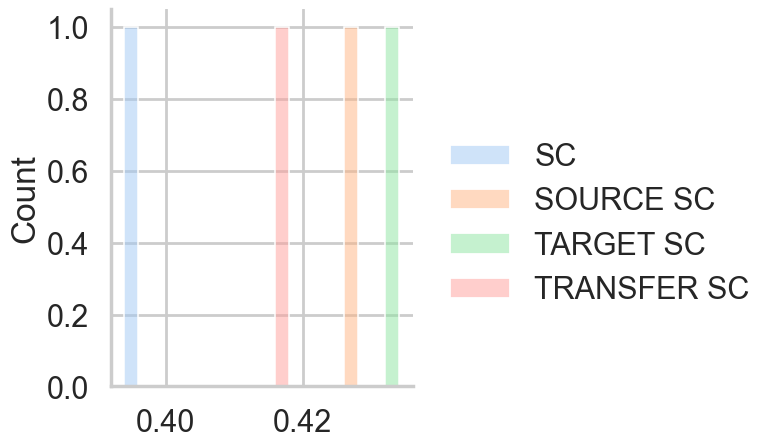

<Figure size 1500x1600 with 0 Axes>

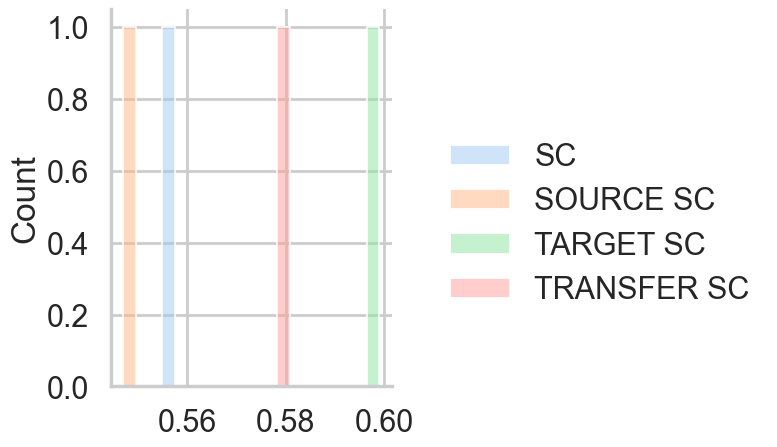

<Figure size 1500x1600 with 0 Axes>

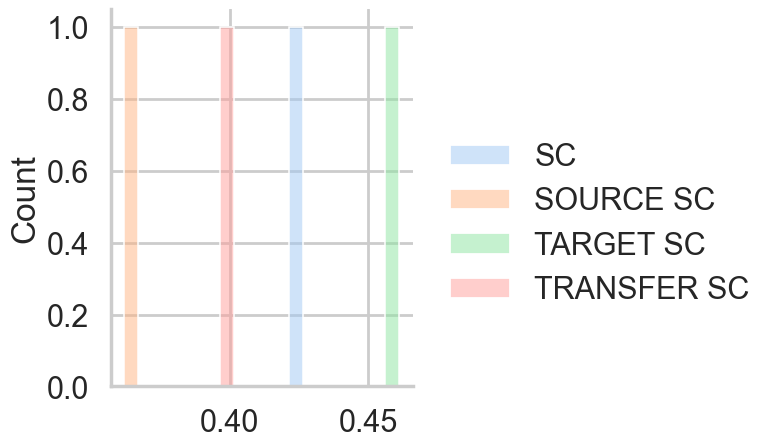

<Figure size 1500x1600 with 0 Axes>

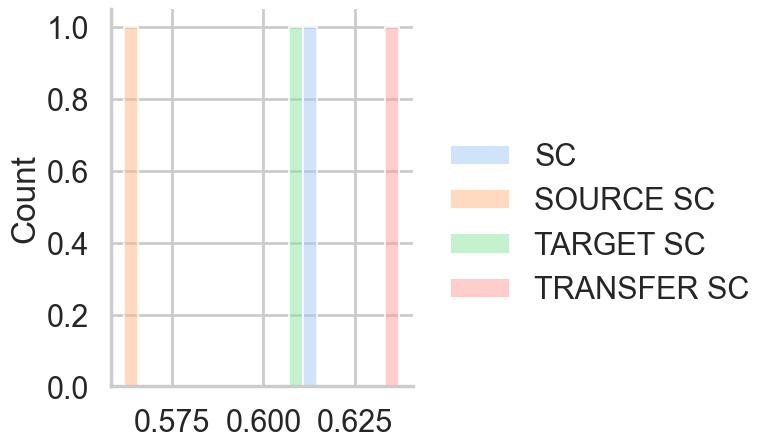

<Figure size 1500x1600 with 0 Axes>

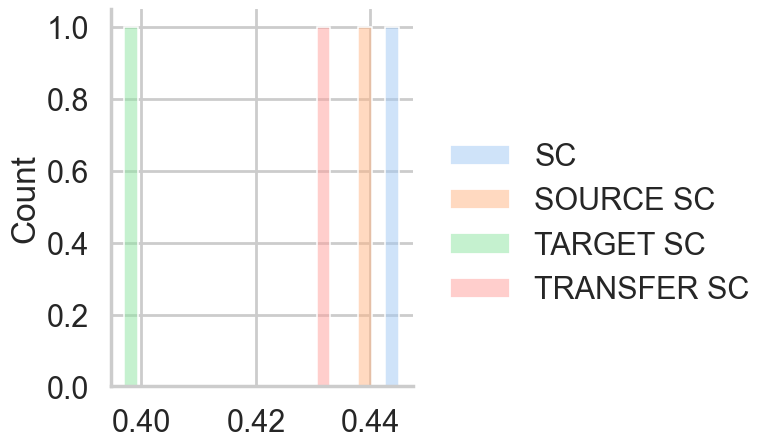

<Figure size 1500x1600 with 0 Axes>

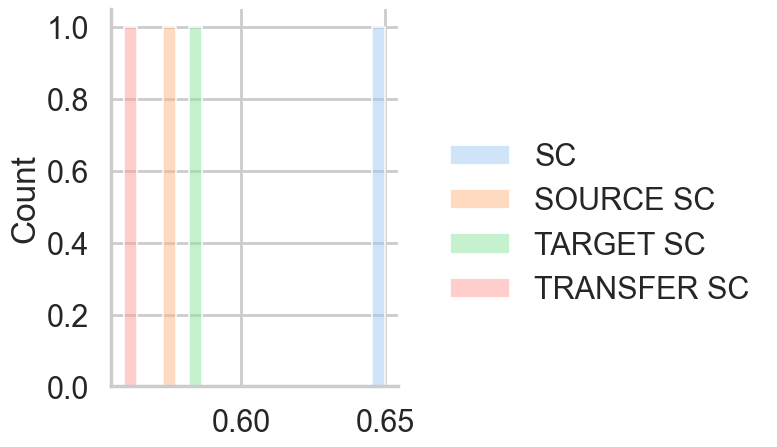

<Figure size 1500x1600 with 0 Axes>

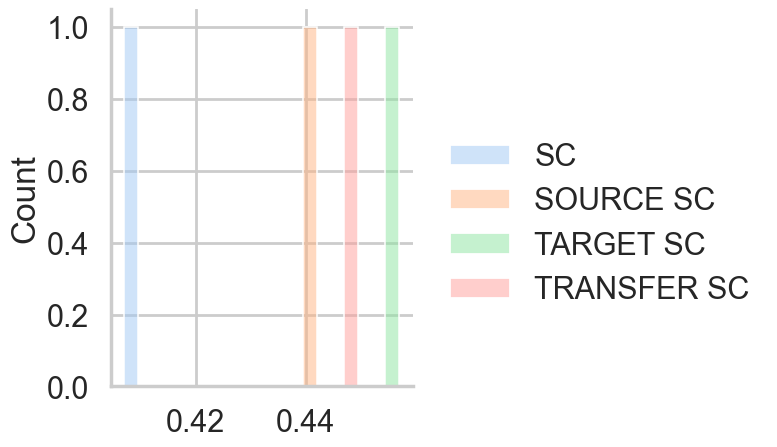

<Figure size 1500x1600 with 0 Axes>

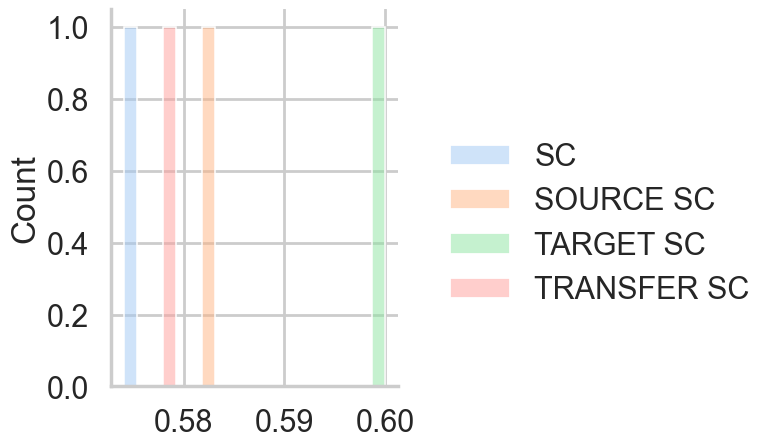

<Figure size 1500x1600 with 0 Axes>

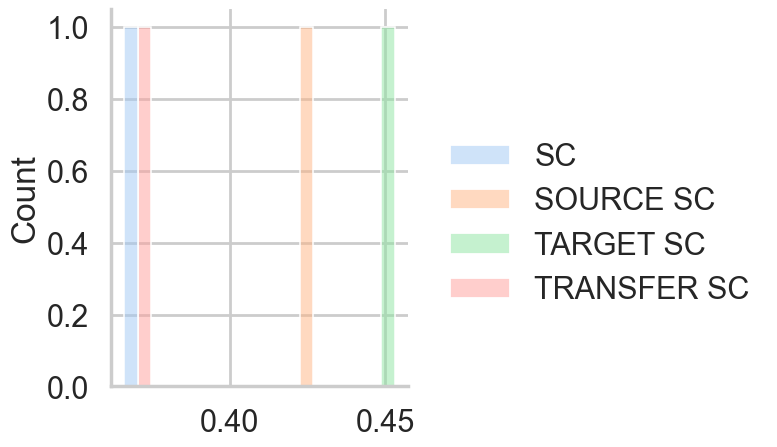

<Figure size 1500x1600 with 0 Axes>

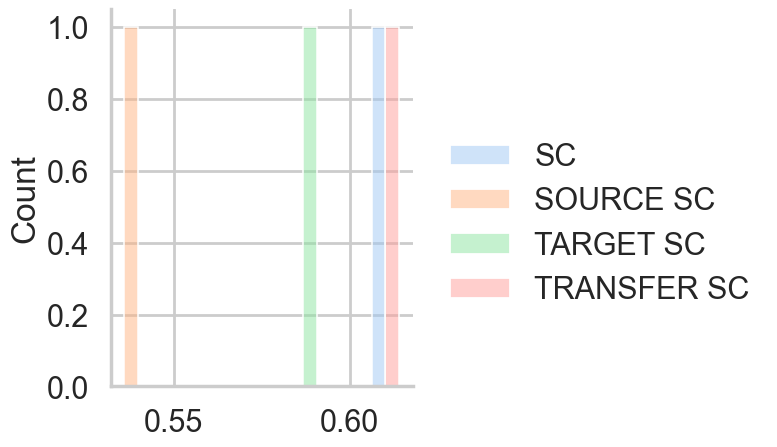

<Figure size 1500x1600 with 0 Axes>

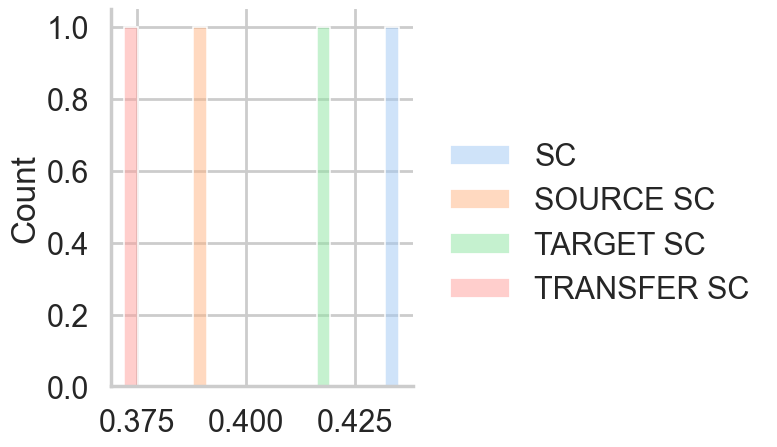

<Figure size 1500x1600 with 0 Axes>

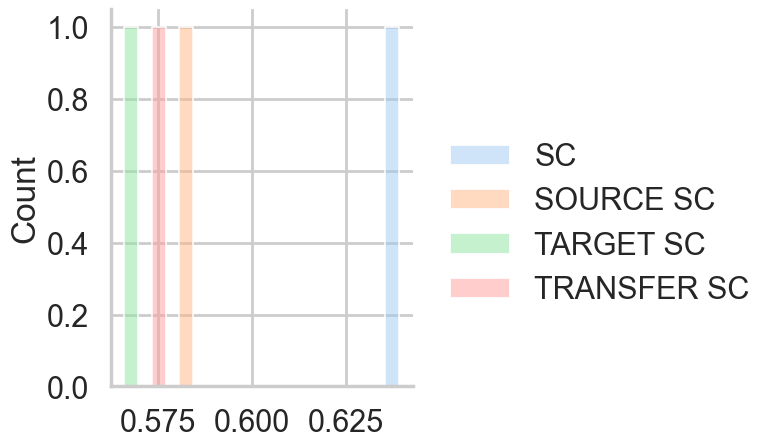

<Figure size 1500x1600 with 0 Axes>

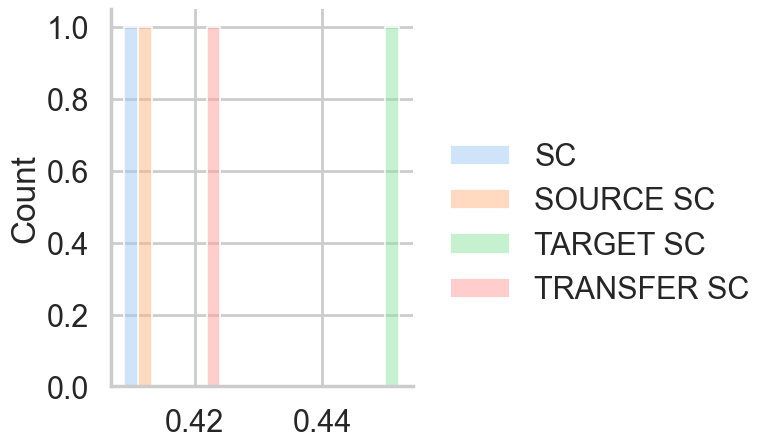

<Figure size 1500x1600 with 0 Axes>

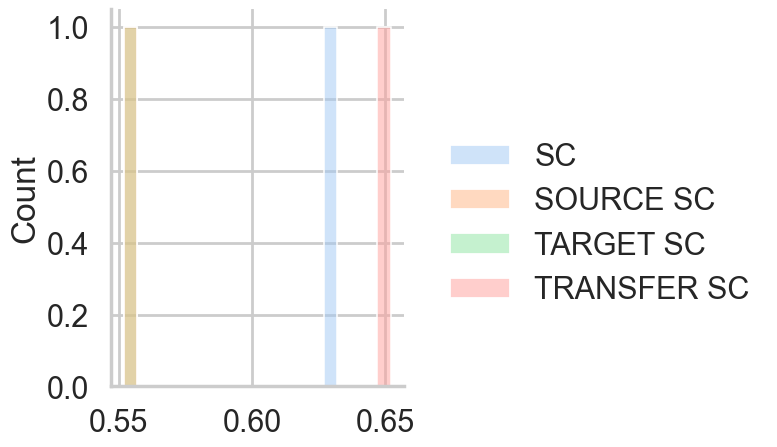

<Figure size 1500x1600 with 0 Axes>

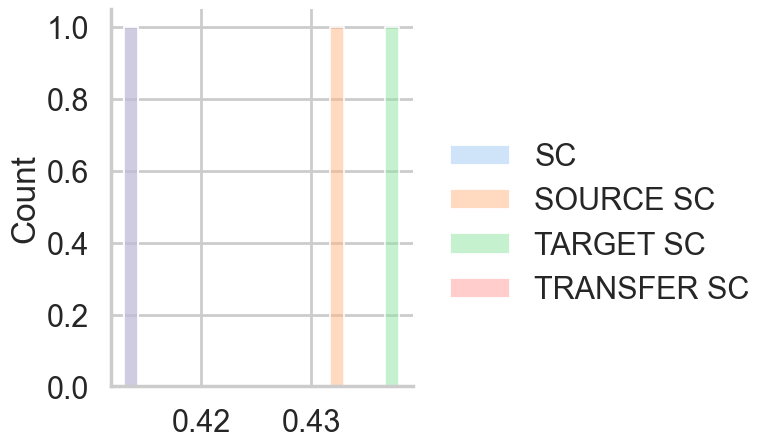

<Figure size 1500x1600 with 0 Axes>

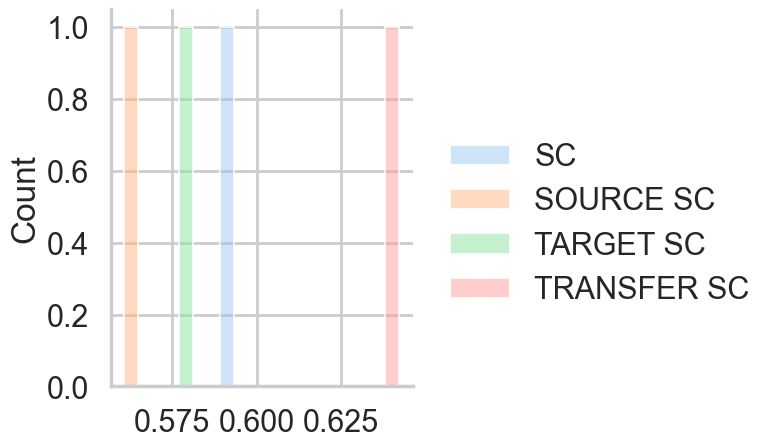

<Figure size 1500x1600 with 0 Axes>

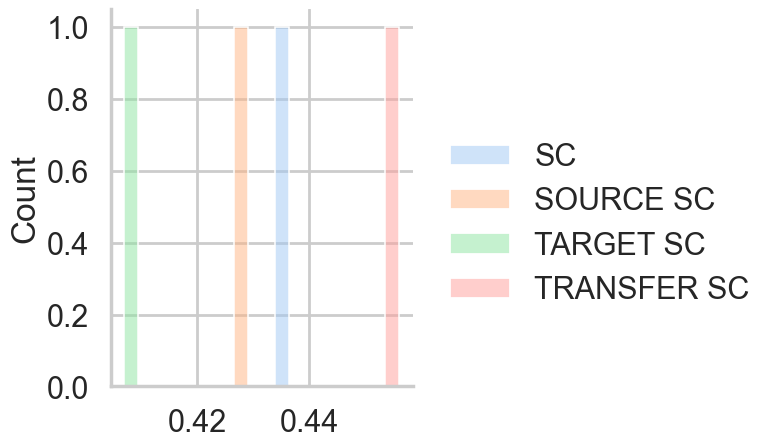

<Figure size 1500x1600 with 0 Axes>

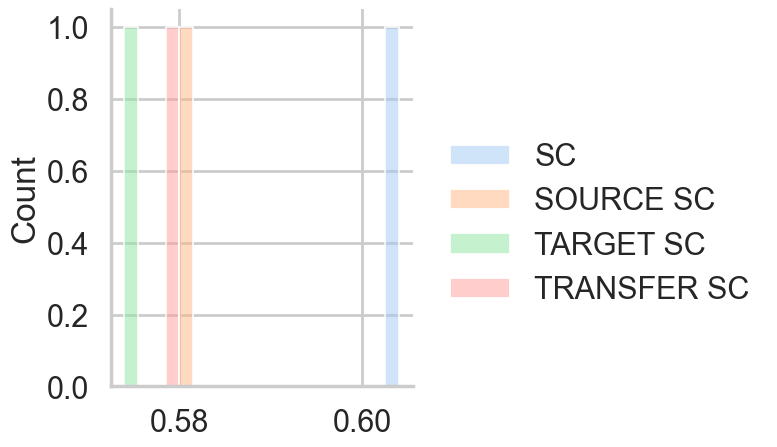

<Figure size 1500x1600 with 0 Axes>

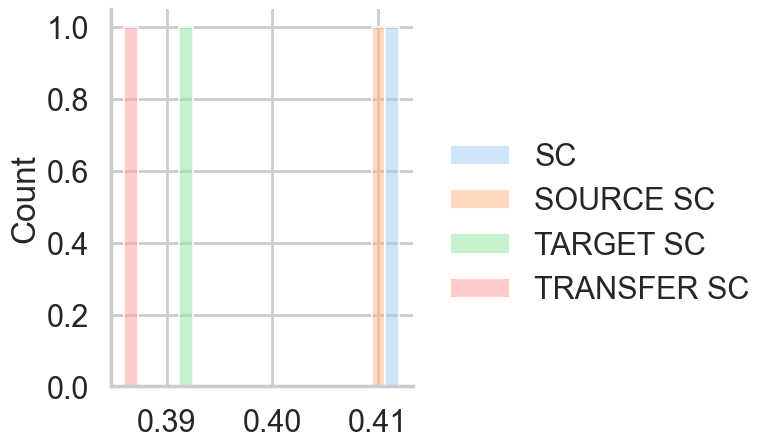

<Figure size 1500x1600 with 0 Axes>

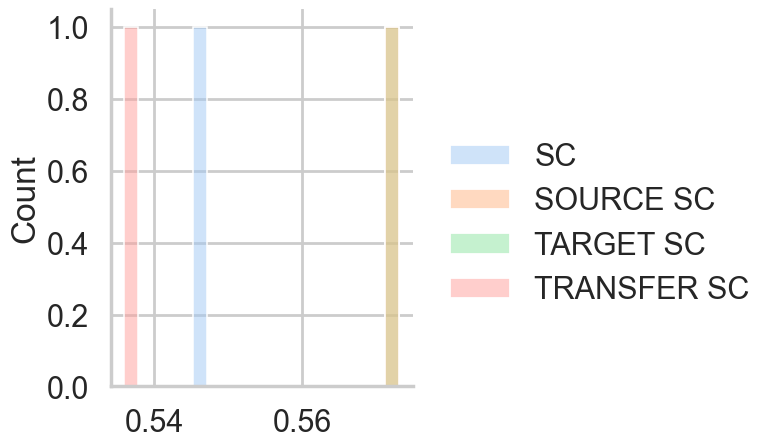

In [56]:
t_ini = time.time()

general_params = {'weeks_to_train': 1, 'rp': 0.6, 'max_iter': 2000}
nnsc_params = {'gradient_step_size': 10**(-10), 'epsilon': 10**(-8), 'steps': 4001, 'n_components': 25}
dd_params = {'dd_steps': 50, 'dd_epsilon': 10**(-3), 'dd_mu': 10**(-6)}

transfer_params = {'a': 0.5, 'b': 0.5}
n_components = nnsc_params['n_components']

t_0 = time.time()

nrmses, nrmses_nz = [], []

nb_iterations_train = 10
sc_total, ssc_total, tarsc_total, tsc_total = 0, 0, 0, 0
sc_nz_total, ssc_nz_total, tarsc_nz_total, tsc_nz_total = 0, 0, 0, 0
for i in range(nb_iterations_train):
    with contextlib.redirect_stdout(None):
        A_list, B_list, errors, dsc = nnsc_train_block(split=False)
        A_list_source_only, B_list_source_only, errors_source_only, dsc_source_only = nnsc_train_block(split=True, keep_target=False)
        A_list_target_only, B_list_target_only, errors, dsc = nnsc_train_block(split=True, keep_target=True)
        A_list_tsc, B_list_tsc, errors_tsc, dsc_tsc = nnsc_train_block(split=False, enable_transfer_learning=True)

        # Train DD
        Bs, As, errs = dd_train_block(A_list, B_list, split=False, dsc=dsc)
        Bs_only_target, As_only_target, errs_only_target = dd_train_block(A_list_source_only, B_list_source_only, split=True, dsc=dsc)
        Bs_only_target_from_target, As_only_target_from_target, errs_only_target_from_target = dd_train_block(A_list_target_only, B_list_target_only, split=True, dsc=dsc)
        Bs_tsc, As_tsc, errs_tsc = dd_train_block(A_list_tsc, B_list_tsc, split=False, dsc=dsc)

        # Accuracy
        sc, ssc, tarsc, tsc = overall_accs_report(weeks_to_train, Bs, Bs_only_target, Bs_tsc, Bs_only_target_from_target)
        sc_nz, ssc_nz, tarsc_nz, tsc_nz = overall_non_zero_accs_report(weeks_to_train, Bs, Bs_only_target, Bs_tsc, Bs_only_target_from_target)

        nrmses.append(per_cat_errs_report(weeks_to_train, Bs, Bs_only_target, Bs_tsc, Bs_only_target_from_target))
        nrmses_nz.append(per_cat_errs_report_non_zero(weeks_to_train, Bs, Bs_only_target, Bs_tsc, Bs_only_target_from_target))
        
        sc_total += sc
        ssc_total += ssc
        tarsc_total += tarsc
        tsc_total += tsc

        sc_nz_total += sc_nz
        ssc_nz_total += ssc_nz
        tarsc_nz_total += tarsc_nz
        tsc_nz_total += tsc_nz

        


In [58]:
print('accuracy', sc_total / nb_iterations_train, ssc_total / nb_iterations_train, tarsc_total / nb_iterations_train, tsc_total / nb_iterations_train)
print('non zero accuracy', sc_nz_total / nb_iterations_train, ssc_nz_total / nb_iterations_train, tarsc_nz_total / nb_iterations_train, tsc_nz_total / nb_iterations_train, '\n')



accuracy 0.414 0.4164 0.43100000000000005 0.41200000000000003
non zero accuracy 0.6011 0.5655 0.5824999999999999 0.5951000000000001 



In [18]:
def round_and_percentage(x, decimals=2):
  return '%' + str(round(x*100, decimals))

def round_and_tabulate(accs, models):
    '''
    accs is a dict where keys are metrics and values are accuracies for models (in order)
    '''
    accs = {k: [round_and_percentage(x, 2) for x in v] for k, v in accs.items()}
    df = pd.DataFrame(accs)
    df.index = models
    return df

df = round_and_tabulate(
    accs={
        'Eacc': [sc_total / nb_iterations_train, ssc_total / nb_iterations_train, tarsc_total / nb_iterations_train, tsc_total / nb_iterations_train],
        'Eacc != 0': [sc_nz_total / nb_iterations_train, ssc_nz_total / nb_iterations_train, tarsc_nz_total / nb_iterations_train, tsc_nz_total / nb_iterations_train],    
    },
    models=['SC+DD', 'SC source, DD target', 'SC target, DD target', 'TSC+DD']
)
print(df.to_latex())

\begin{tabular}{lll}
\toprule
{} &   Eacc & Eacc != 0 \\
\midrule
SC+DD                &  \%41.7 &     \%62.9 \\
SC source, DD target &  \%38.8 &     \%58.0 \\
SC target, DD target &  \%44.0 &     \%60.8 \\
TSC+DD               &  \%41.0 &     \%65.8 \\
\bottomrule
\end{tabular}



In [19]:
def get_errs_avg(errs):
    fridges = [[d[0]['fridge'] for d in x[-4:]] for x in nrmses]
    washing_drying = [[d[0]['washing_drying'] for d in x[-4:]] for x in nrmses]
    avg_rmse = {
        'fridge_rmse': [np.mean([x[ind][0] for x in fridges]) for ind in range(len(fridges[0]))],
        'fridge_nrmse': [round_and_percentage(np.mean([x[ind][1] for x in fridges]), 1) for ind in range(len(fridges[0]))],
        'washing_drying_rmse': [np.mean([x[ind][0] for x in washing_drying]) for ind in range(len(washing_drying[0]))],
        'washing_drying_nrmse': [round_and_percentage(np.mean([x[ind][1] for x in washing_drying]), 1) for ind in range(len(washing_drying[0]))],
        
        
    }
    return avg_rmse

errs_dict = get_errs_avg(nrmses)
df = pd.DataFrame(errs_dict).T
df.columns = ['SC+DD', 'SC source, DD target', 'SC target, DD target', 'TSC+DD']
df

SC+DD SC source, DD target SC target, DD target  \
fridge_rmse           110.169088           105.222533           111.908719   
fridge_nrmse                %4.6                 %4.4                 %4.7   
washing_drying_rmse   479.199443             485.5606           485.181548   
washing_drying_nrmse        %3.5                 %3.6                 %3.6   

                          TSC+DD  
fridge_rmse            99.218435  
fridge_nrmse                %4.2  
washing_drying_rmse   484.033929  
washing_drying_nrmse        %3.6

In [20]:
print(df.T.to_latex())

\begin{tabular}{lllll}
\toprule
{} & fridge\_rmse & fridge\_nrmse & washing\_drying\_rmse & washing\_drying\_nrmse \\
\midrule
SC+DD                &  110.169088 &         \%4.6 &          479.199443 &                 \%3.5 \\
SC source, DD target &  105.222533 &         \%4.4 &            485.5606 &                 \%3.6 \\
SC target, DD target &  111.908719 &         \%4.7 &          485.181548 &                 \%3.6 \\
TSC+DD               &   99.218435 &         \%4.2 &          484.033929 &                 \%3.6 \\
\bottomrule
\end{tabular}



### Consumption Plots

In [59]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

method_dict = {
    'SC mix, DD mix': (As, Bs),
    'SC source, DD target': (As_only_target, Bs_only_target),
    'SC target, DD target': (As_only_target_from_target ,Bs_only_target_from_target),
    'Transfer SC+DD': (As_tsc, Bs_tsc),
}
colors = ['orange', 'green', 'purple', 'red']

In [60]:
def get_all_agg_plots(data, nb_houses, nb_weeks, data_type='test'):
    figs, axes = [], []
    for week in range(nb_weeks):
        fig, ax = plt.subplots(figsize=(20, 20), nrows=nb_houses)
        plt.suptitle('Week {}'.format(week), fontsize=20)
        
        for house in range(nb_houses):
            xt = data[week]['X_bar']
            #for ind, cat in enumerate(all_categories):
            ax[house].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
            legend = []
            house_name = xt.columns[house]
            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                legend.append(method)
                A_test = dsc.F_obj(x=data[week]['X_bar'].values, B=B[week],rp_gl=dsc.rp)
                abt = np.dot(B[week], A_test)
                ax[house].plot([i*100 for i in range(len(abt))], abt[:,house], c=colors[method_ind], alpha=0.5)
            ax[house].set_xlabel('Timestamp', fontsize=10)
            ax[house].set_ylabel('Consumption', fontsize=10)
            ax[house].set_title('DD for {} house {}, aggregate signal reconstruction'.format(data_type, house_name), fontsize=14)
            ax[house].legend(['real'] + legend)
        figs.append(fig)
        axes.append(ax)
        
    #with PdfPages('plots/all_aggregate_plots_{}_{}.pdf'.format(data_type, data_source)) as pdf:
    #    for fig in figs:
    #        pdf.savefig(fig)

            
            
def get_all_agg_plots_by_method(data, nb_houses, nb_weeks, data_type='test'):
    figs, axes = [], []
    for week in range(nb_weeks):        
        for house in range(nb_houses):
            fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
            xt = data[week]['X_bar']
            house_name = xt.columns[house]
            plt.suptitle('Week {}, house {}'.format(week, house_name), fontsize=20)

            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                A_test = dsc.F_obj(x=data[week]['X_bar'].values, B=B[week],rp_gl=dsc.rp)
                abt = np.dot(B[week], A_test)
                ax[method_ind].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
                ax[method_ind].plot([i*100 for i in range(len(abt))], abt[:,house], c=colors[method_ind], alpha=0.5)
                ax[method_ind].set_xlabel('Timestamp', fontsize=24)
                ax[method_ind].set_ylabel('Consumption', fontsize=24)
                ax[method_ind].set_title('DD for {} house {}, method={}, aggregate signal reconstruction'.format(data_type, house_name, method), fontsize=26)
                ax[method_ind].legend(['real', 'predicted'])
            plt.tight_layout()
            figs.append(fig)
            axes.append(ax)
            
        
    with PdfPages('plots/all_aggregate_plots_by_method_{}_{}.pdf'.format(data_type, data_source)) as pdf:
        for fig in figs:
            pdf.savefig(fig)


In [51]:
#get_all_agg_plots(test, nb_houses =2, nb_weeks=1, data_type='test') # not really nb_weeks, just nb data samples

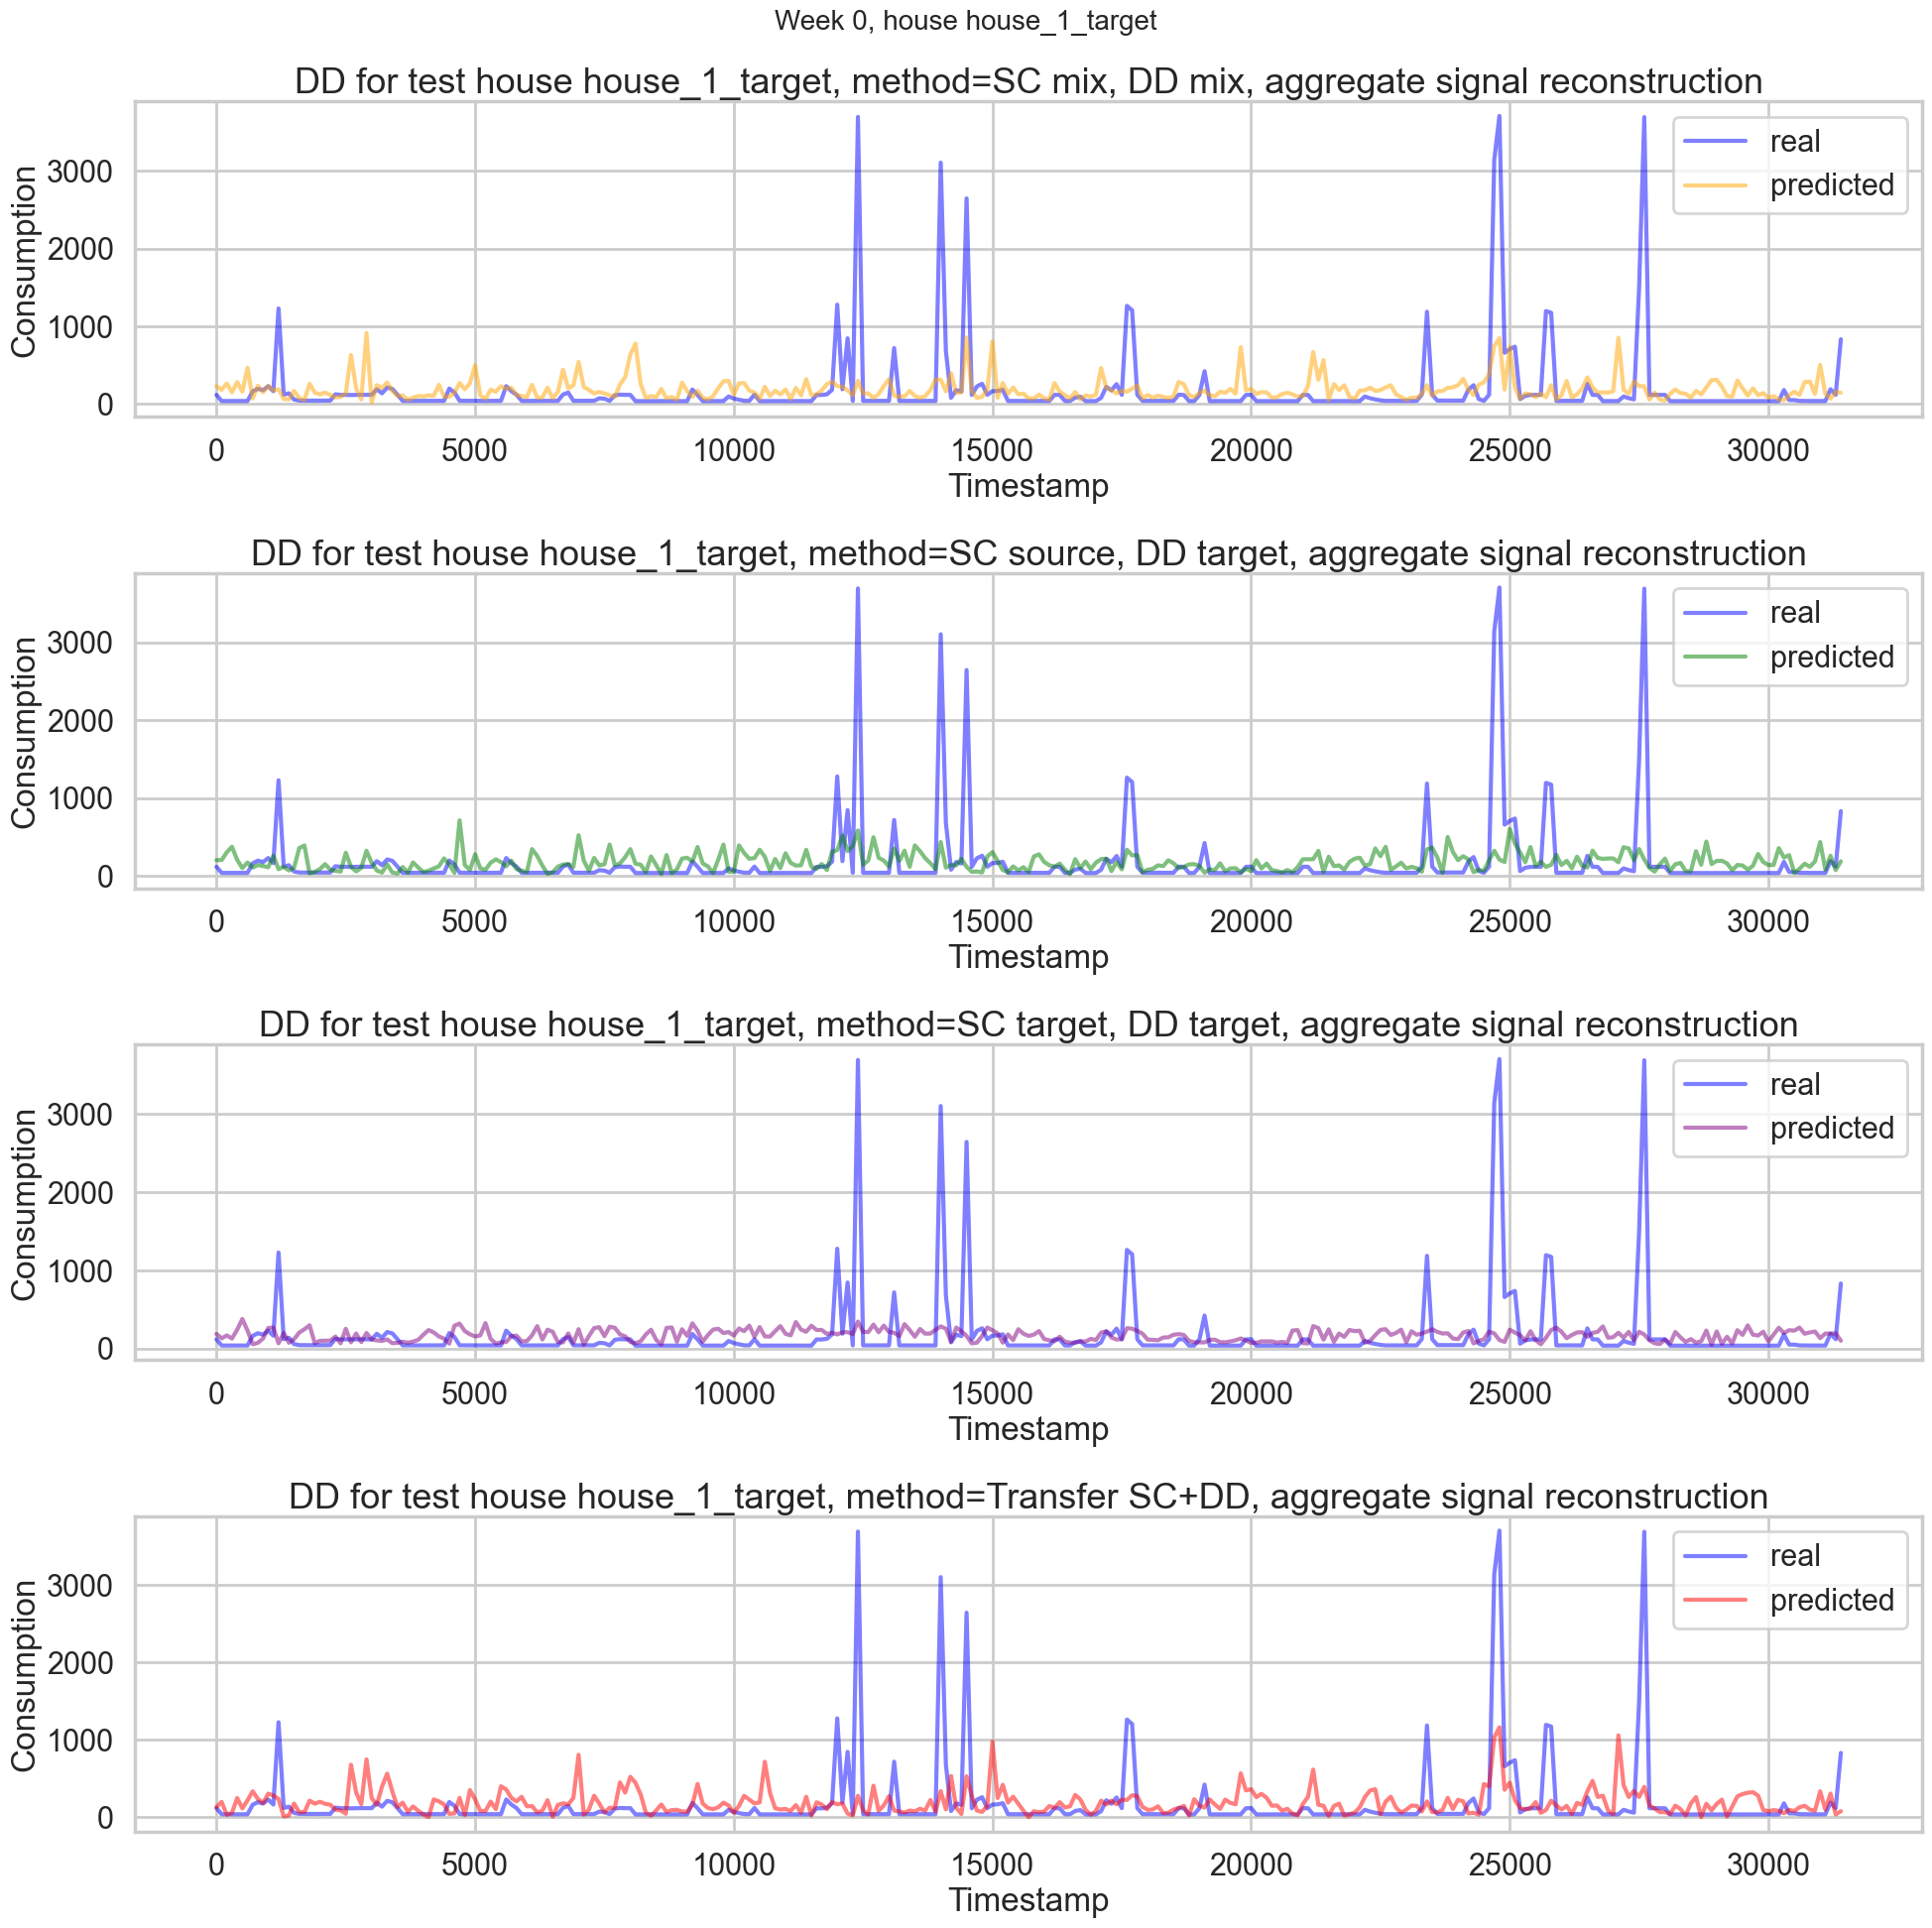

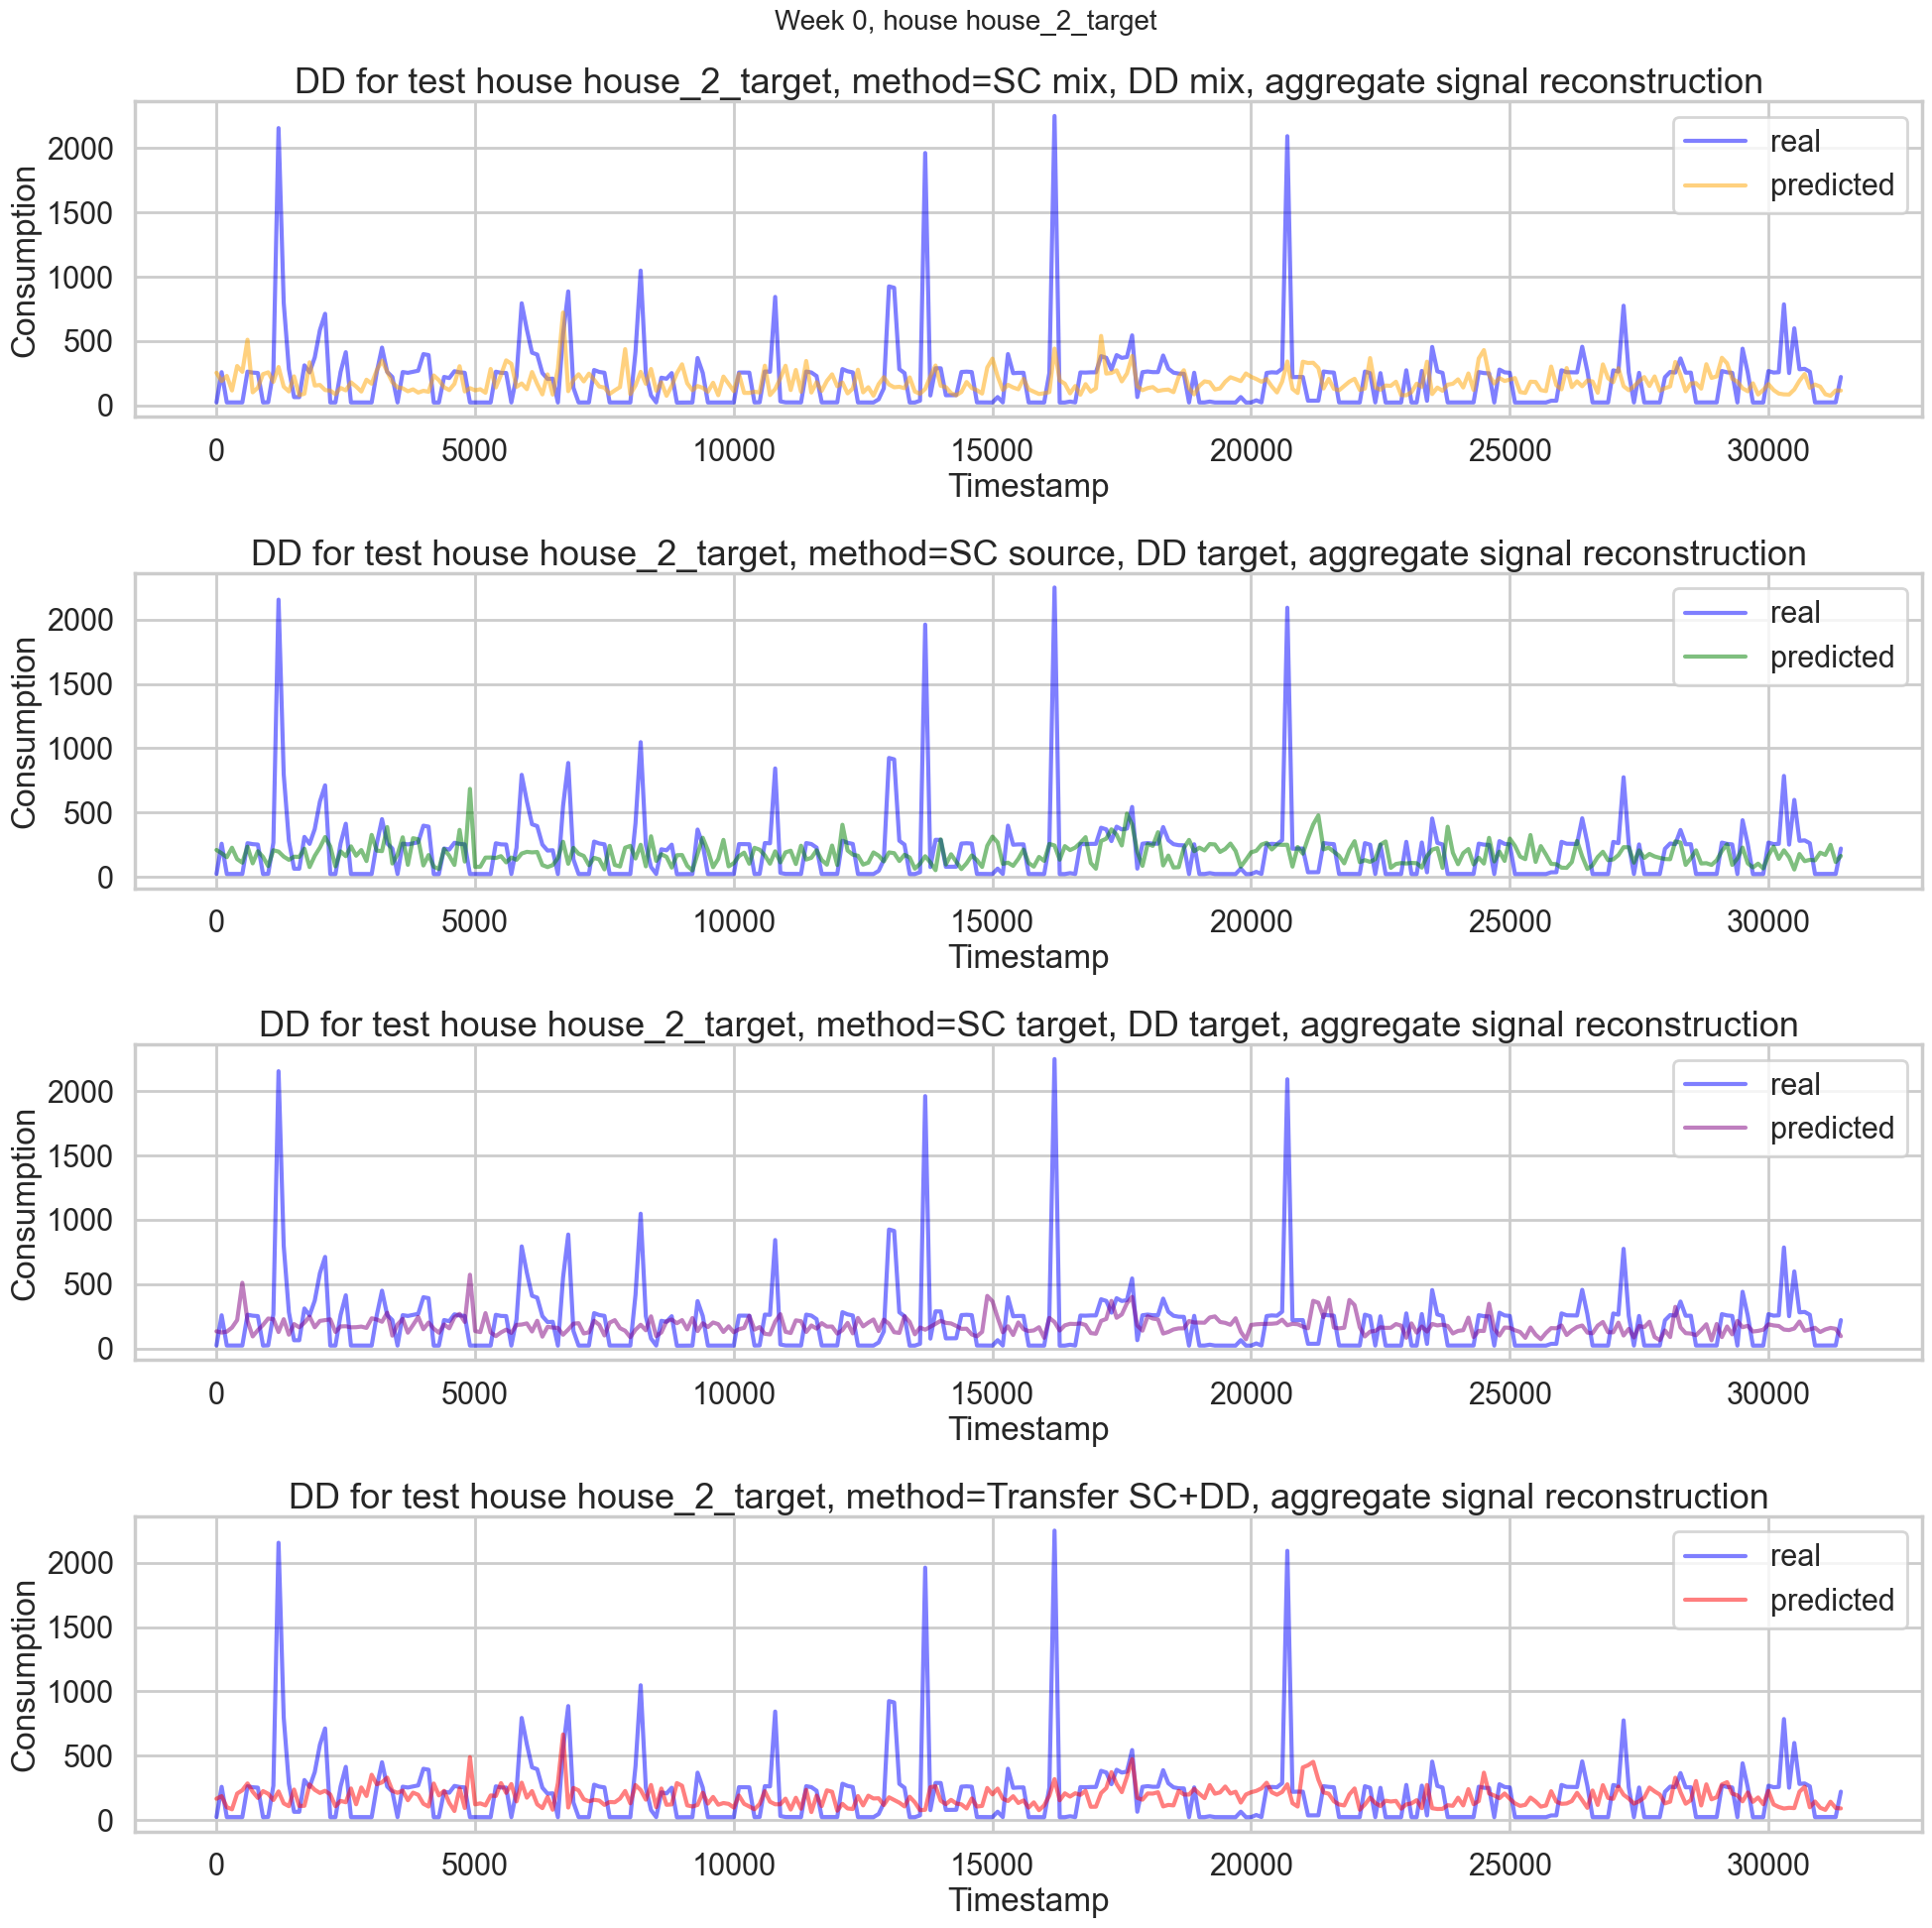

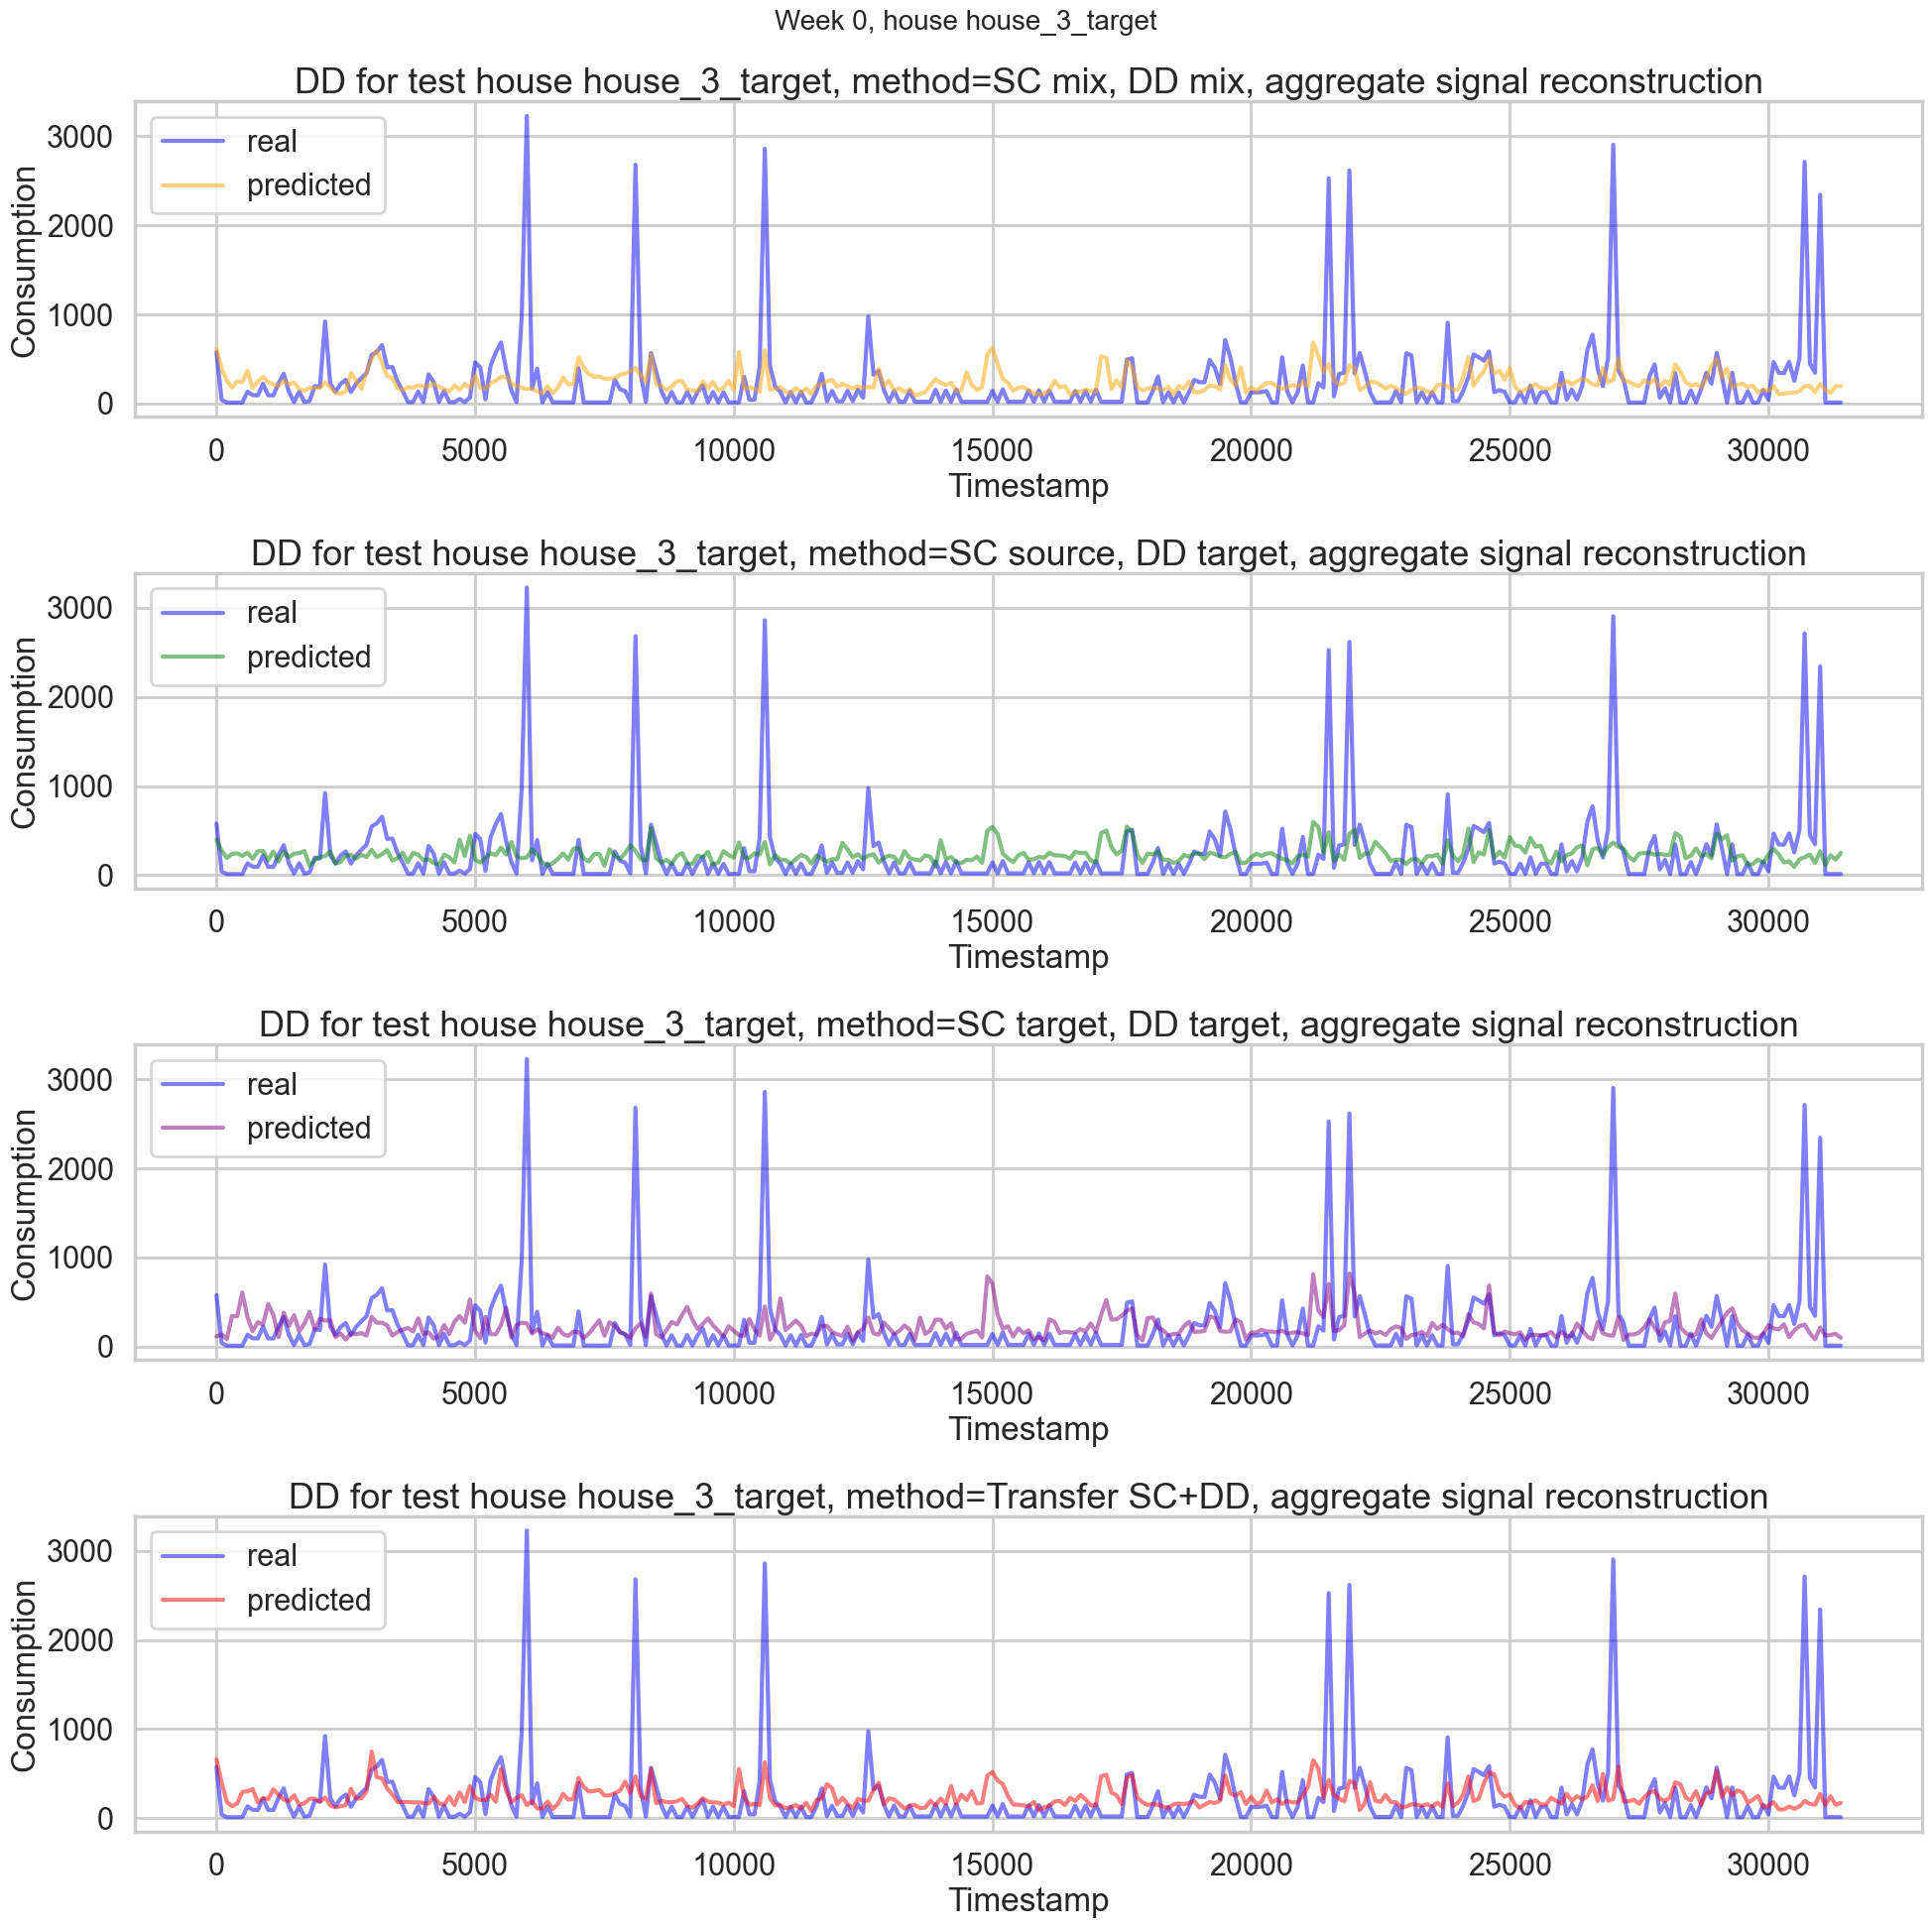

In [61]:
get_all_agg_plots_by_method(test, nb_houses=3, nb_weeks=1, data_type='test') # not really nb_weeks

In [62]:
def get_all_category_plots(data, nb_houses, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    for ind, cat in enumerate(appliance_categories):
        figs, axes = [], []
        for week in range(nb_weeks):
            fig, ax = plt.subplots(figsize=(20, 20), nrows=nb_houses)
            plt.suptitle('Week {}'.format(week), fontsize=20)

            for house in range(nb_houses):
                xt = data[week]['X'][appliance_categories[ind]]
                house_name = xt.columns[house]
                ax[house].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
                legend = []
                for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                    B_test_app = B[week][:,ind*n_components:(ind+1)*n_components]
                    A_test_app = dsc.F_obj(x=data[week]['X'][appliance_categories[ind]].values, B=B_test_app,rp_gl=general_params['rp'])
                    abt = np.dot(B_test_app, A_test_app)
                    
                    legend.append(method)
                    ax[house].plot([i*100 for i in range(len(abt))], abt[:,house], c=colors[method_ind], alpha=0.5)
                ax[house].set_xlabel('Timestamp', fontsize=10)
                ax[house].set_ylabel('Consumption', fontsize=10)
                ax[house].set_title('DD for {} house {}, category={}'.format(data_type, house_name, cat), fontsize=14)
                ax[house].legend(['real'] + legend)
            figs.append(fig)
            axes.append(ax)

        #with PdfPages('plots/all_{}_plots_{}_{}.pdf'.format(cat, data_type, data_source)) as pdf:
        #    for fig in figs:
        #        pdf.savefig(fig)

            
            
def get_all_category_plots_by_method(data, nb_houses, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    for ind, cat in enumerate(appliance_categories):
        figs, axes = [], []
        for week in range(nb_weeks):            
            for house in range(nb_houses):
                
                fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
                xt = data[week]['X'][appliance_categories[ind]]
                house_name = xt.columns[house]
                plt.suptitle('Week {}, house {}'.format(week, house_name), fontsize=20)

                for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                    
                    B_test_app = B[week][:,ind*n_components:(ind+1)*n_components]

                    A_test_app = dsc.F_obj(x=data[week]['X'][cat].values, B=B_test_app,rp_gl=general_params['rp'])
                    abt = np.dot(B_test_app, A_test_app)                    
                    
                    ax[method_ind].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
                    ax[method_ind].plot([i*100 for i in range(len(abt))], abt[:,house], c=colors[method_ind], alpha=0.5)
                    ax[method_ind].set_xlabel('Timestamp', fontsize=24)
                    ax[method_ind].set_ylabel('Consumption', fontsize=24)
                    ax[method_ind].set_title('DD for {} house {}, method={}, category={}'.format(data_type, house_name, method, cat), fontsize=26)
                    ax[method_ind].legend(['real', 'predicted'])
                plt.tight_layout()
                figs.append(fig)
                axes.append(ax)
        
        with PdfPages('plots/all_{}_plots_by_method_{}_{}.pdf'.format(cat, data_type, data_source)) as pdf:
            for fig in figs:
                pdf.savefig(fig)


In [63]:
#get_all_category_plots(test, nb_houses=2, nb_weeks=1, data_type='test')

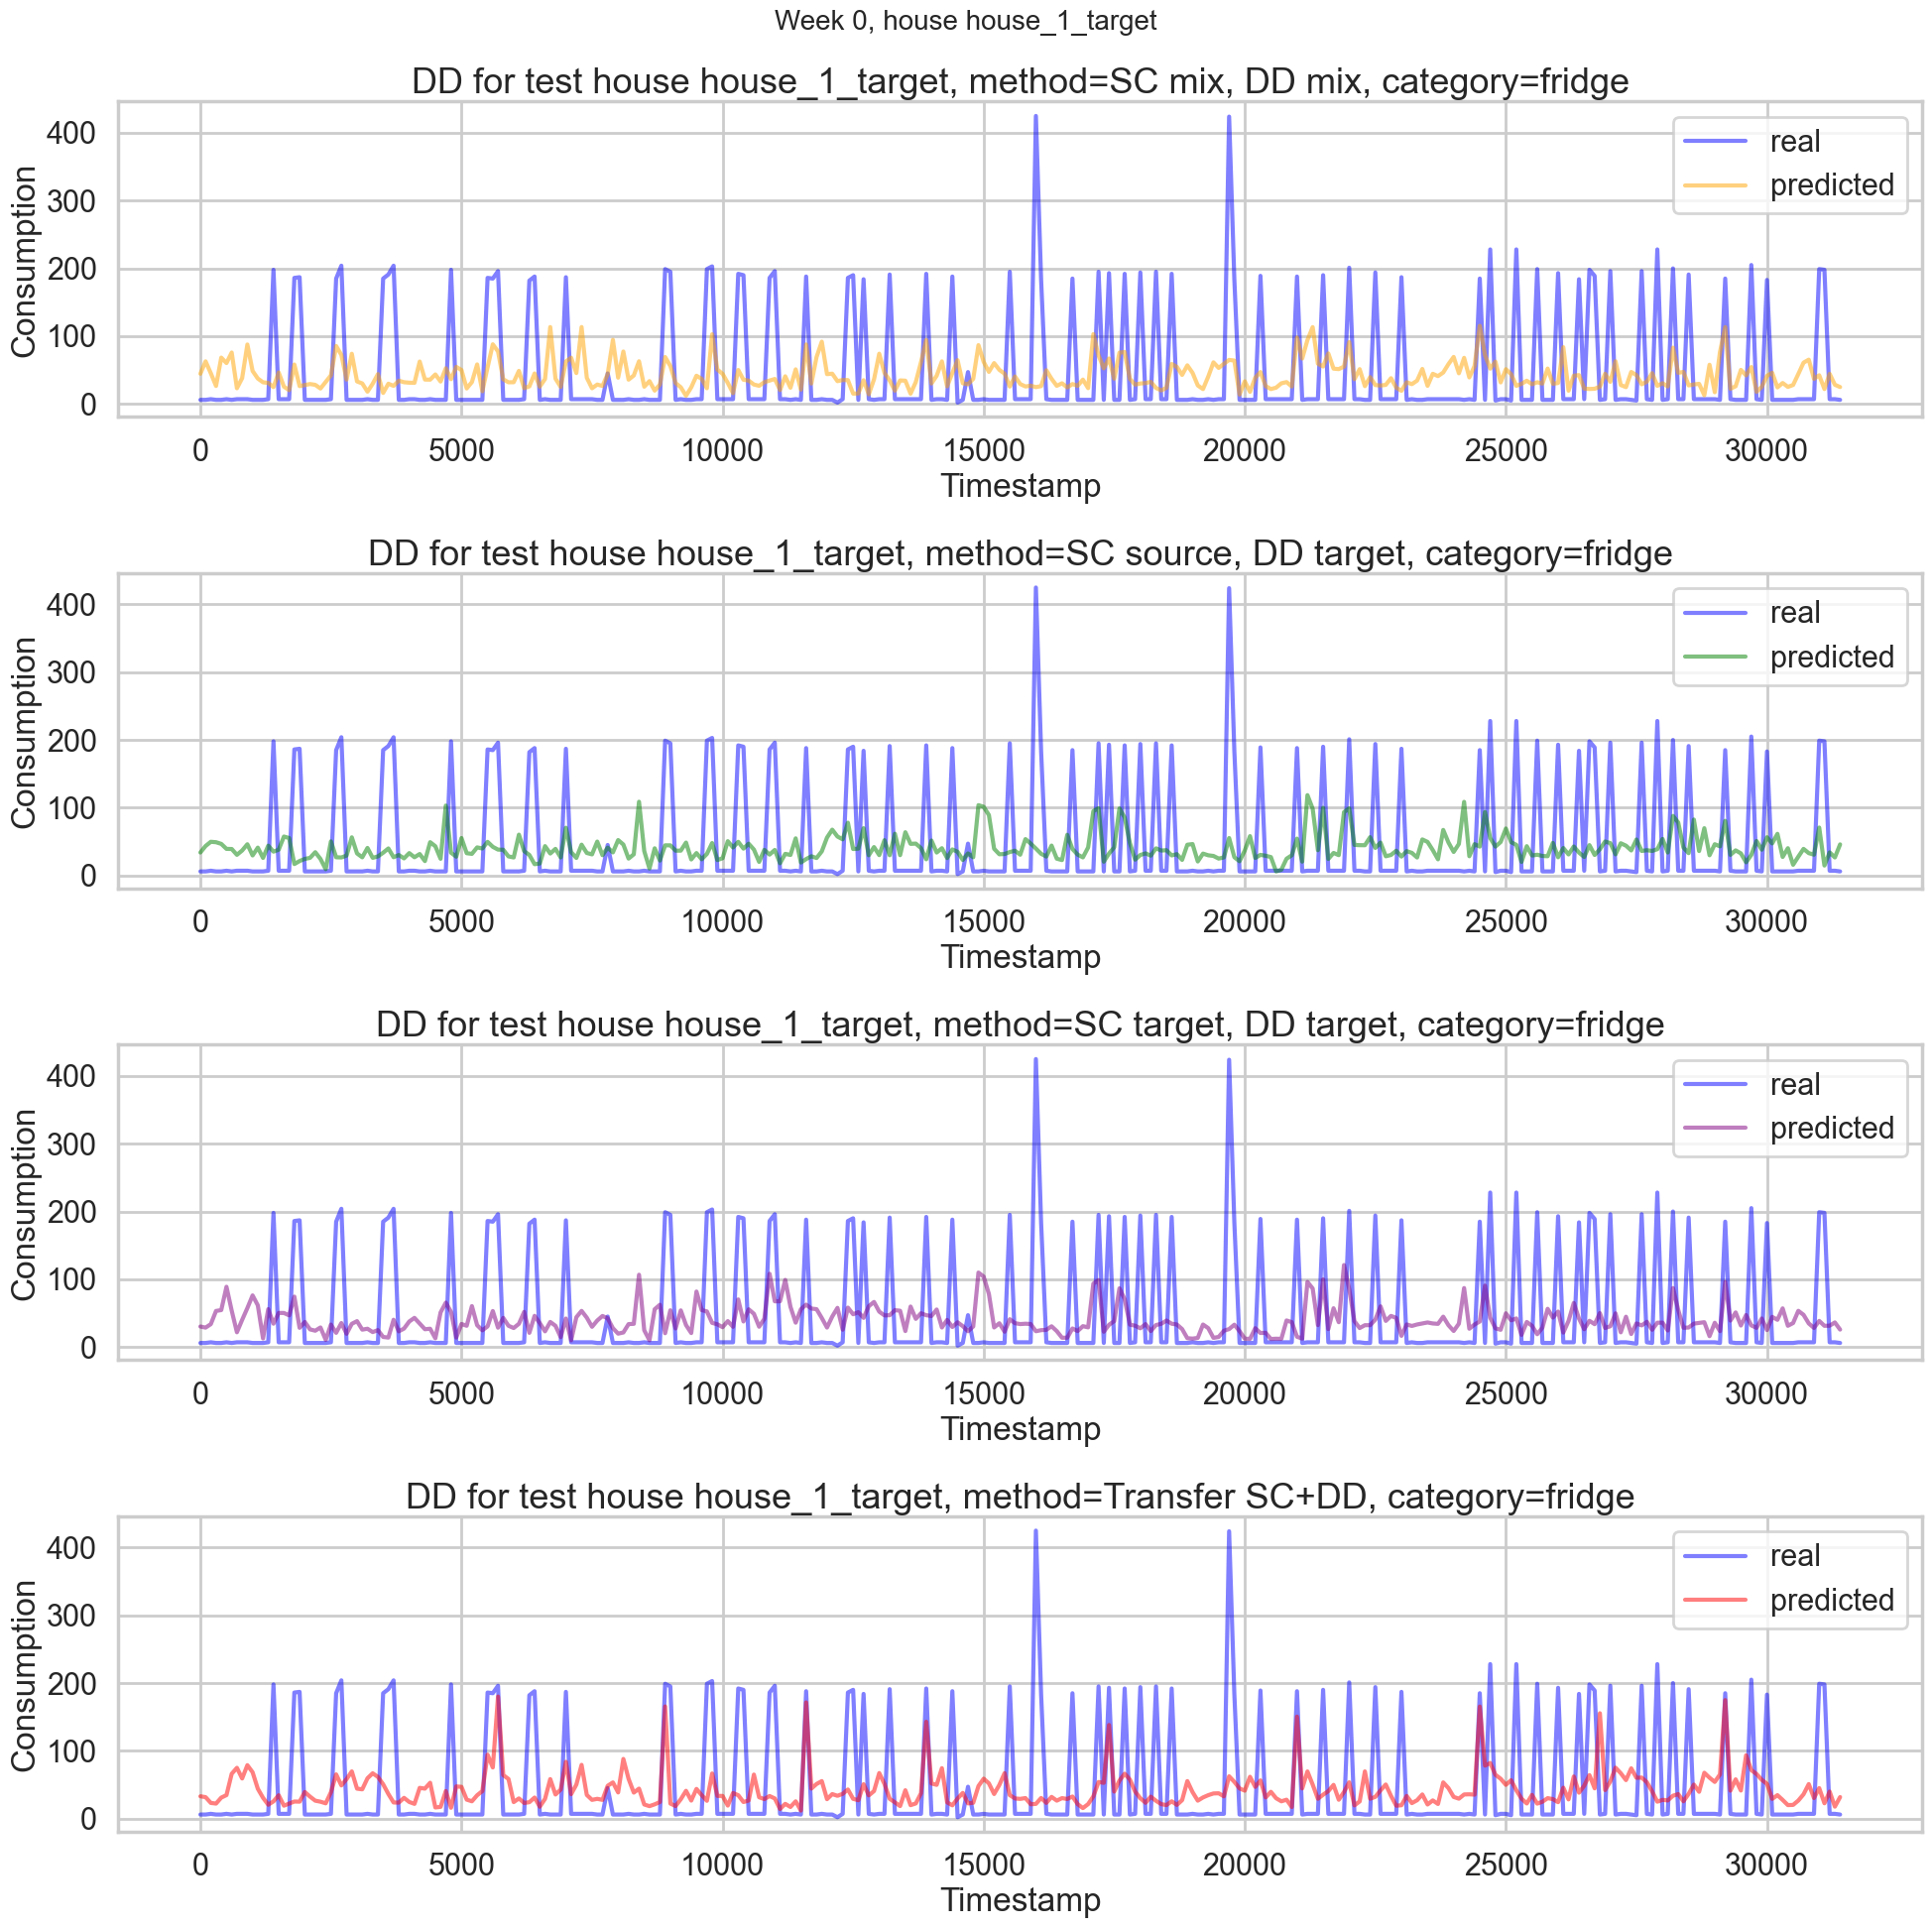

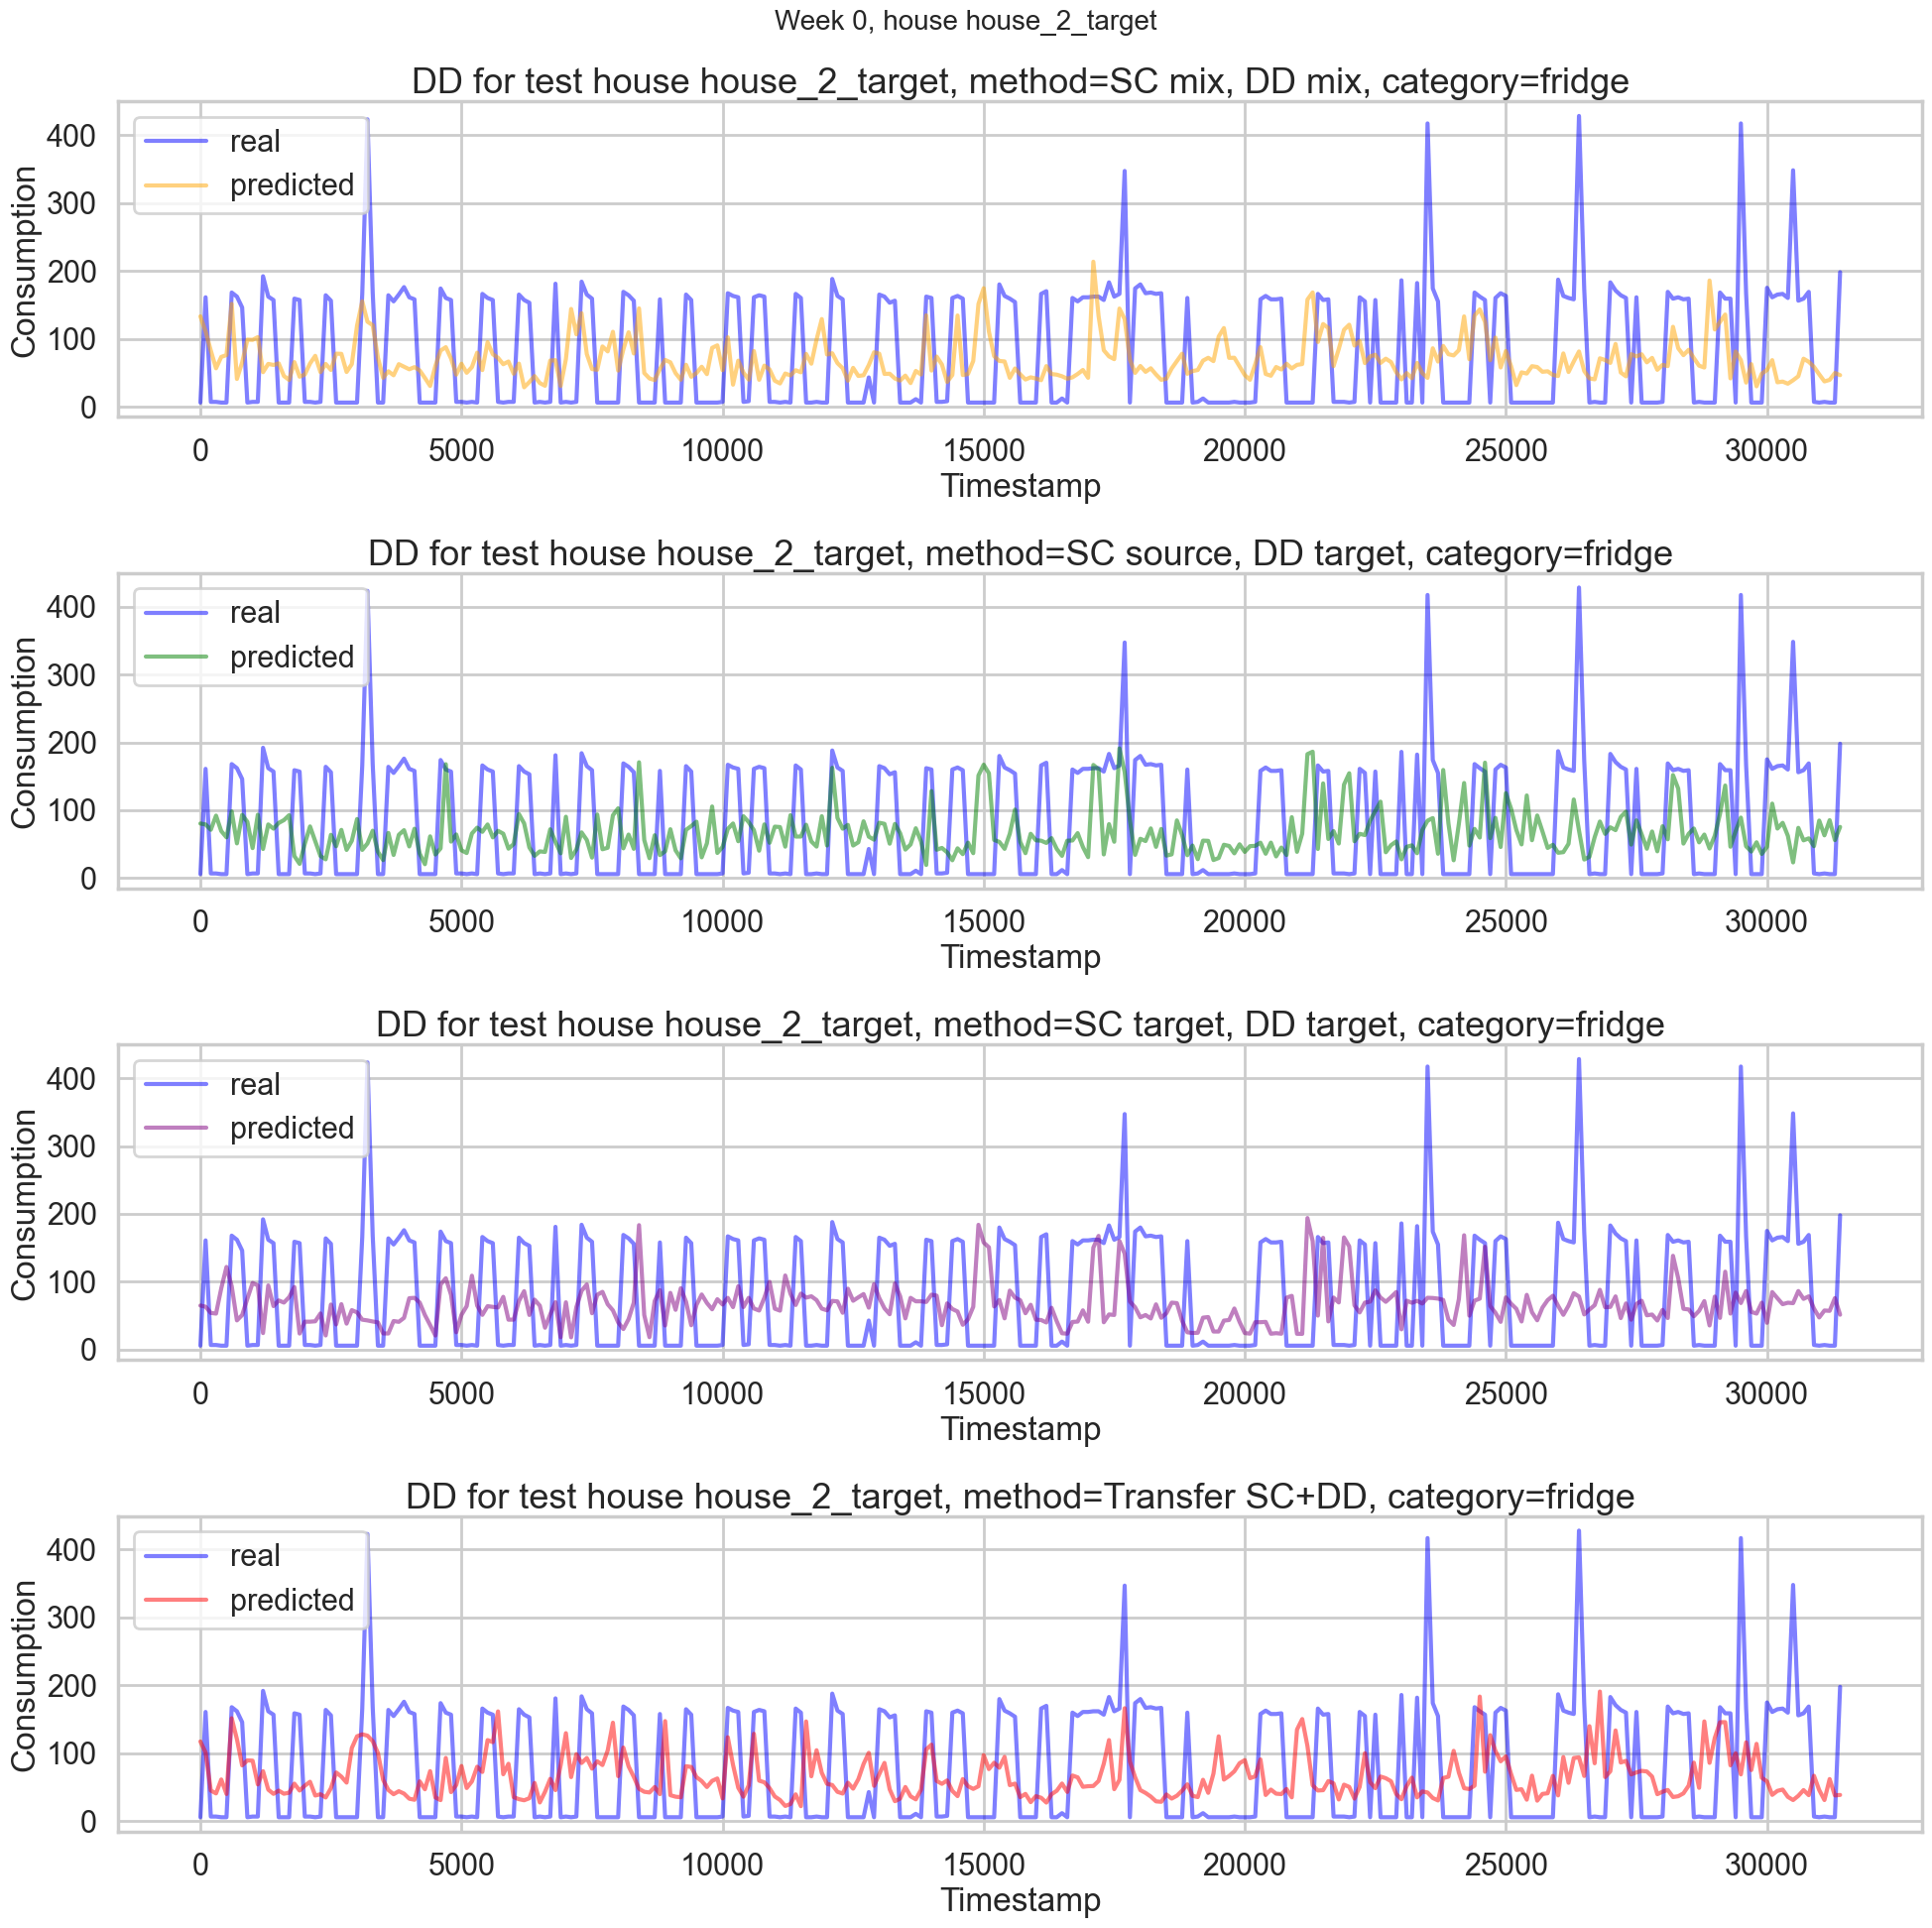

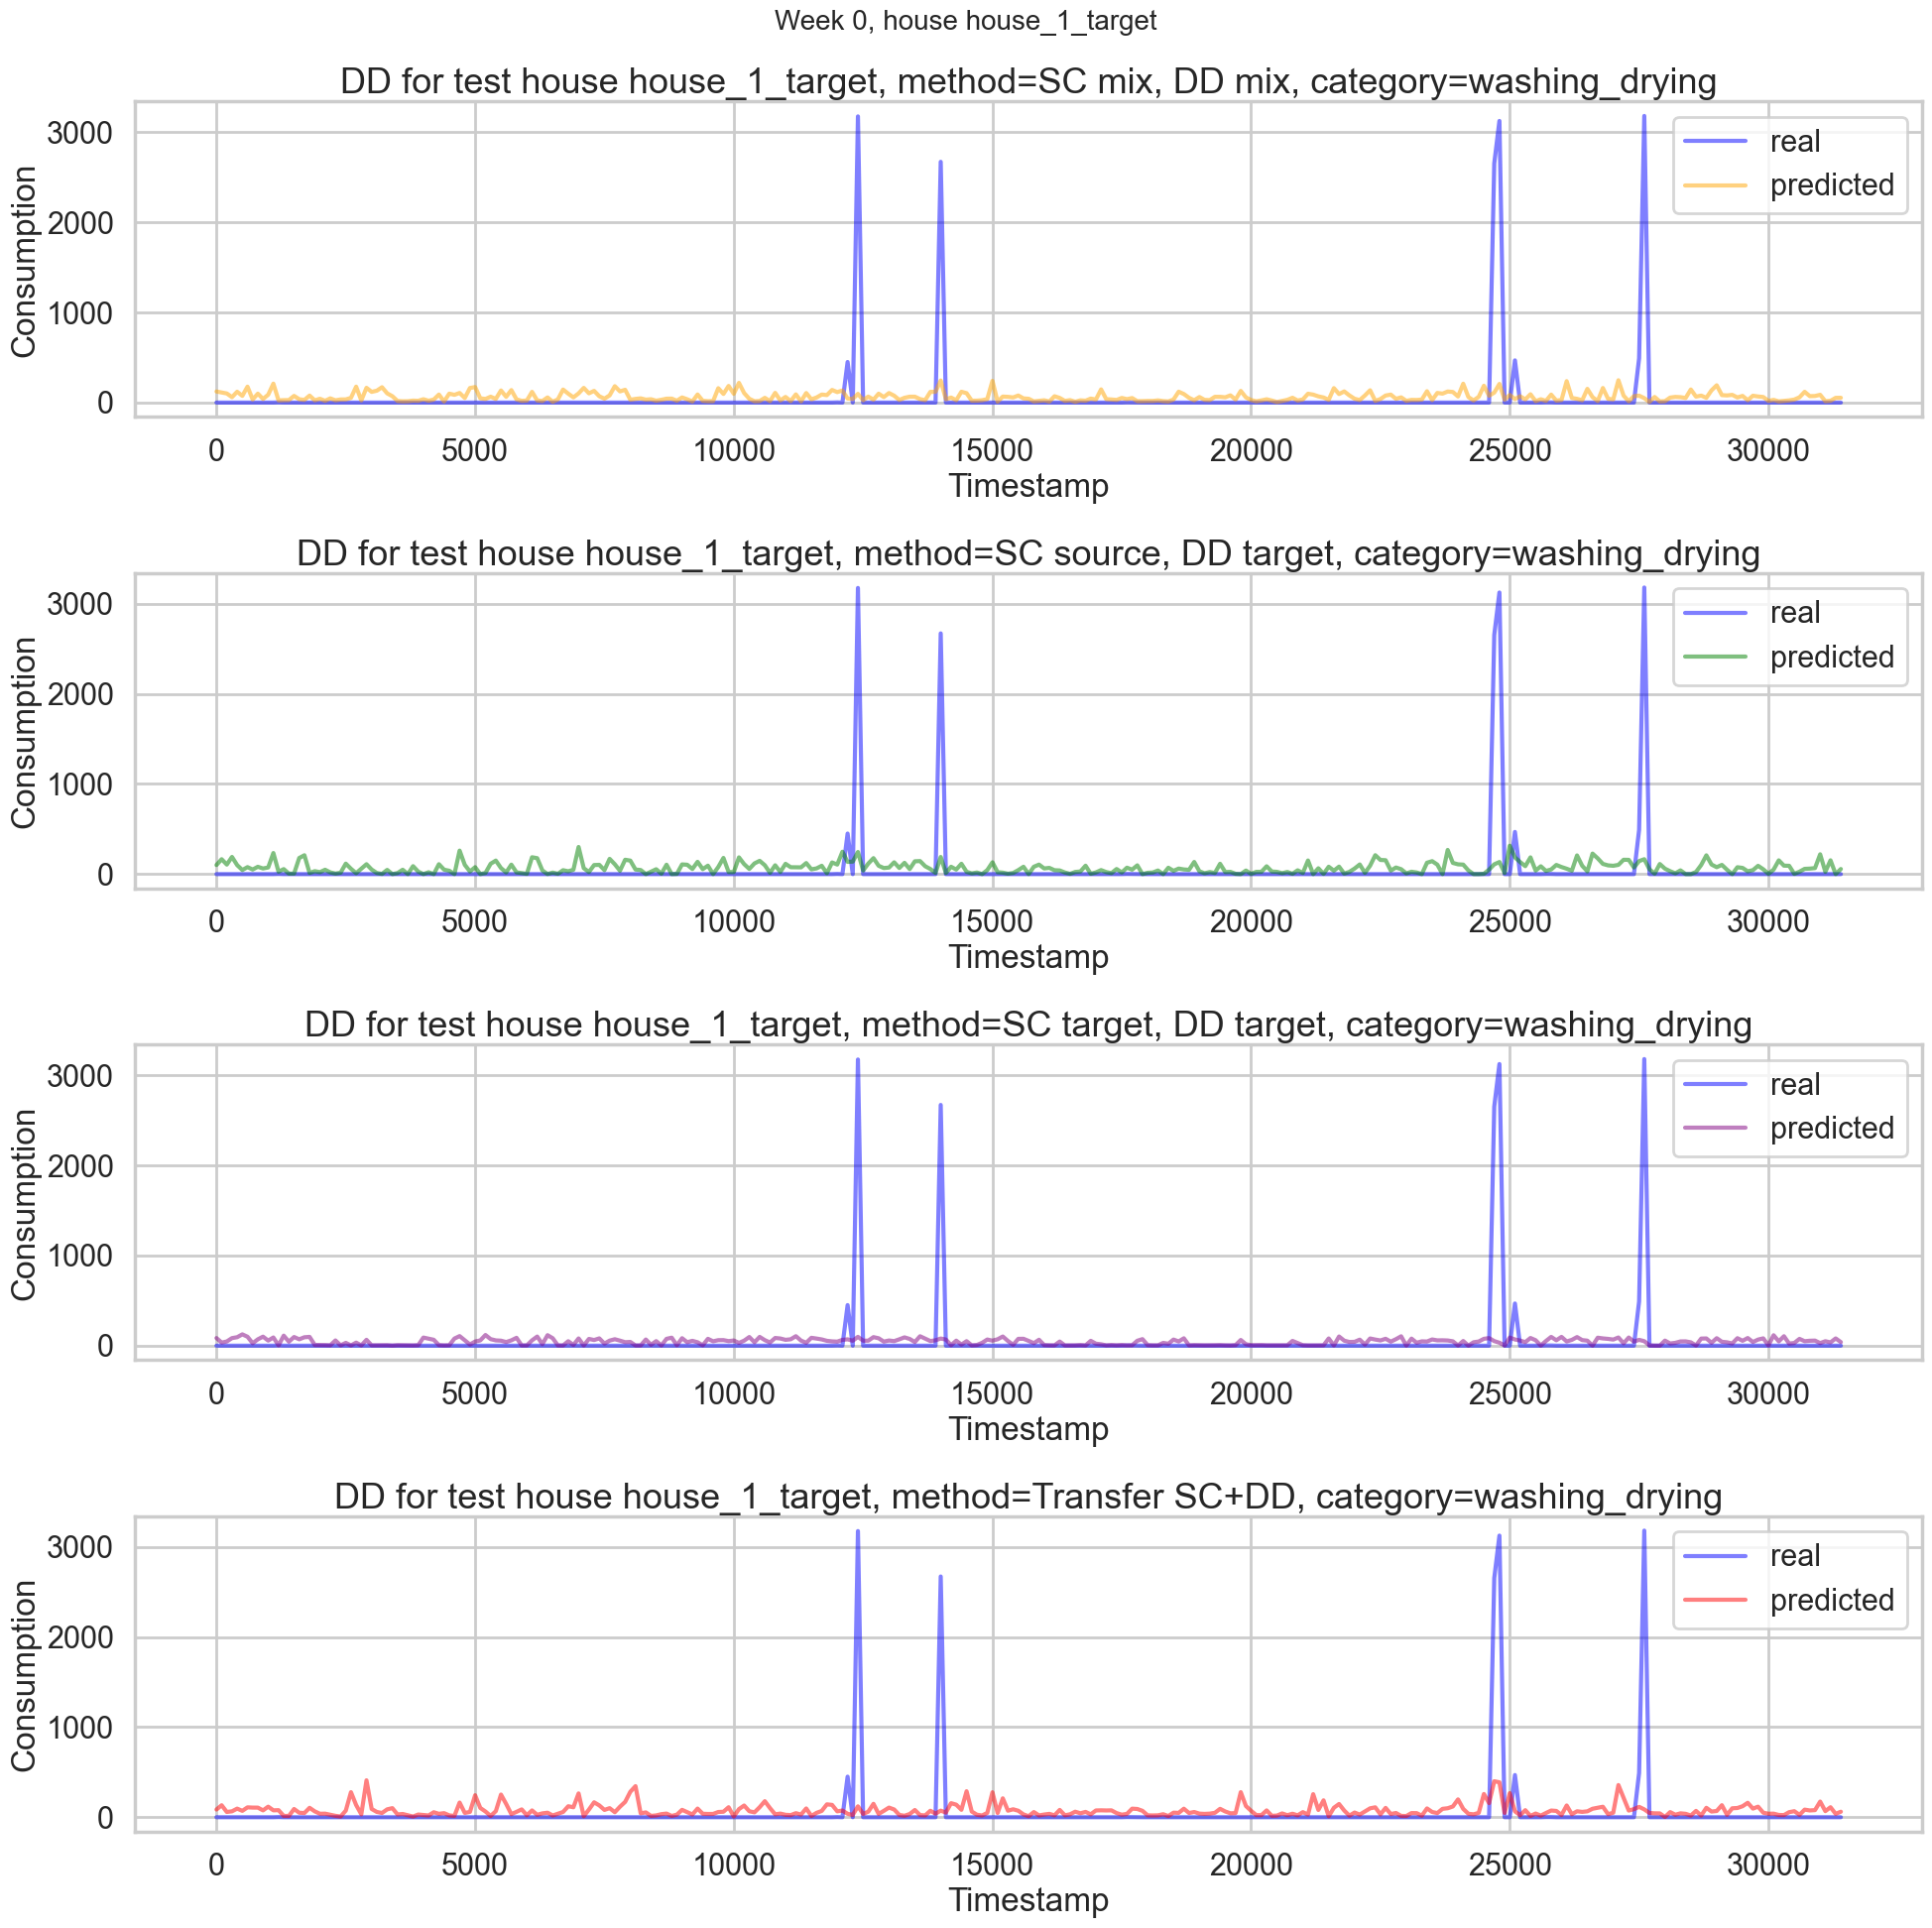

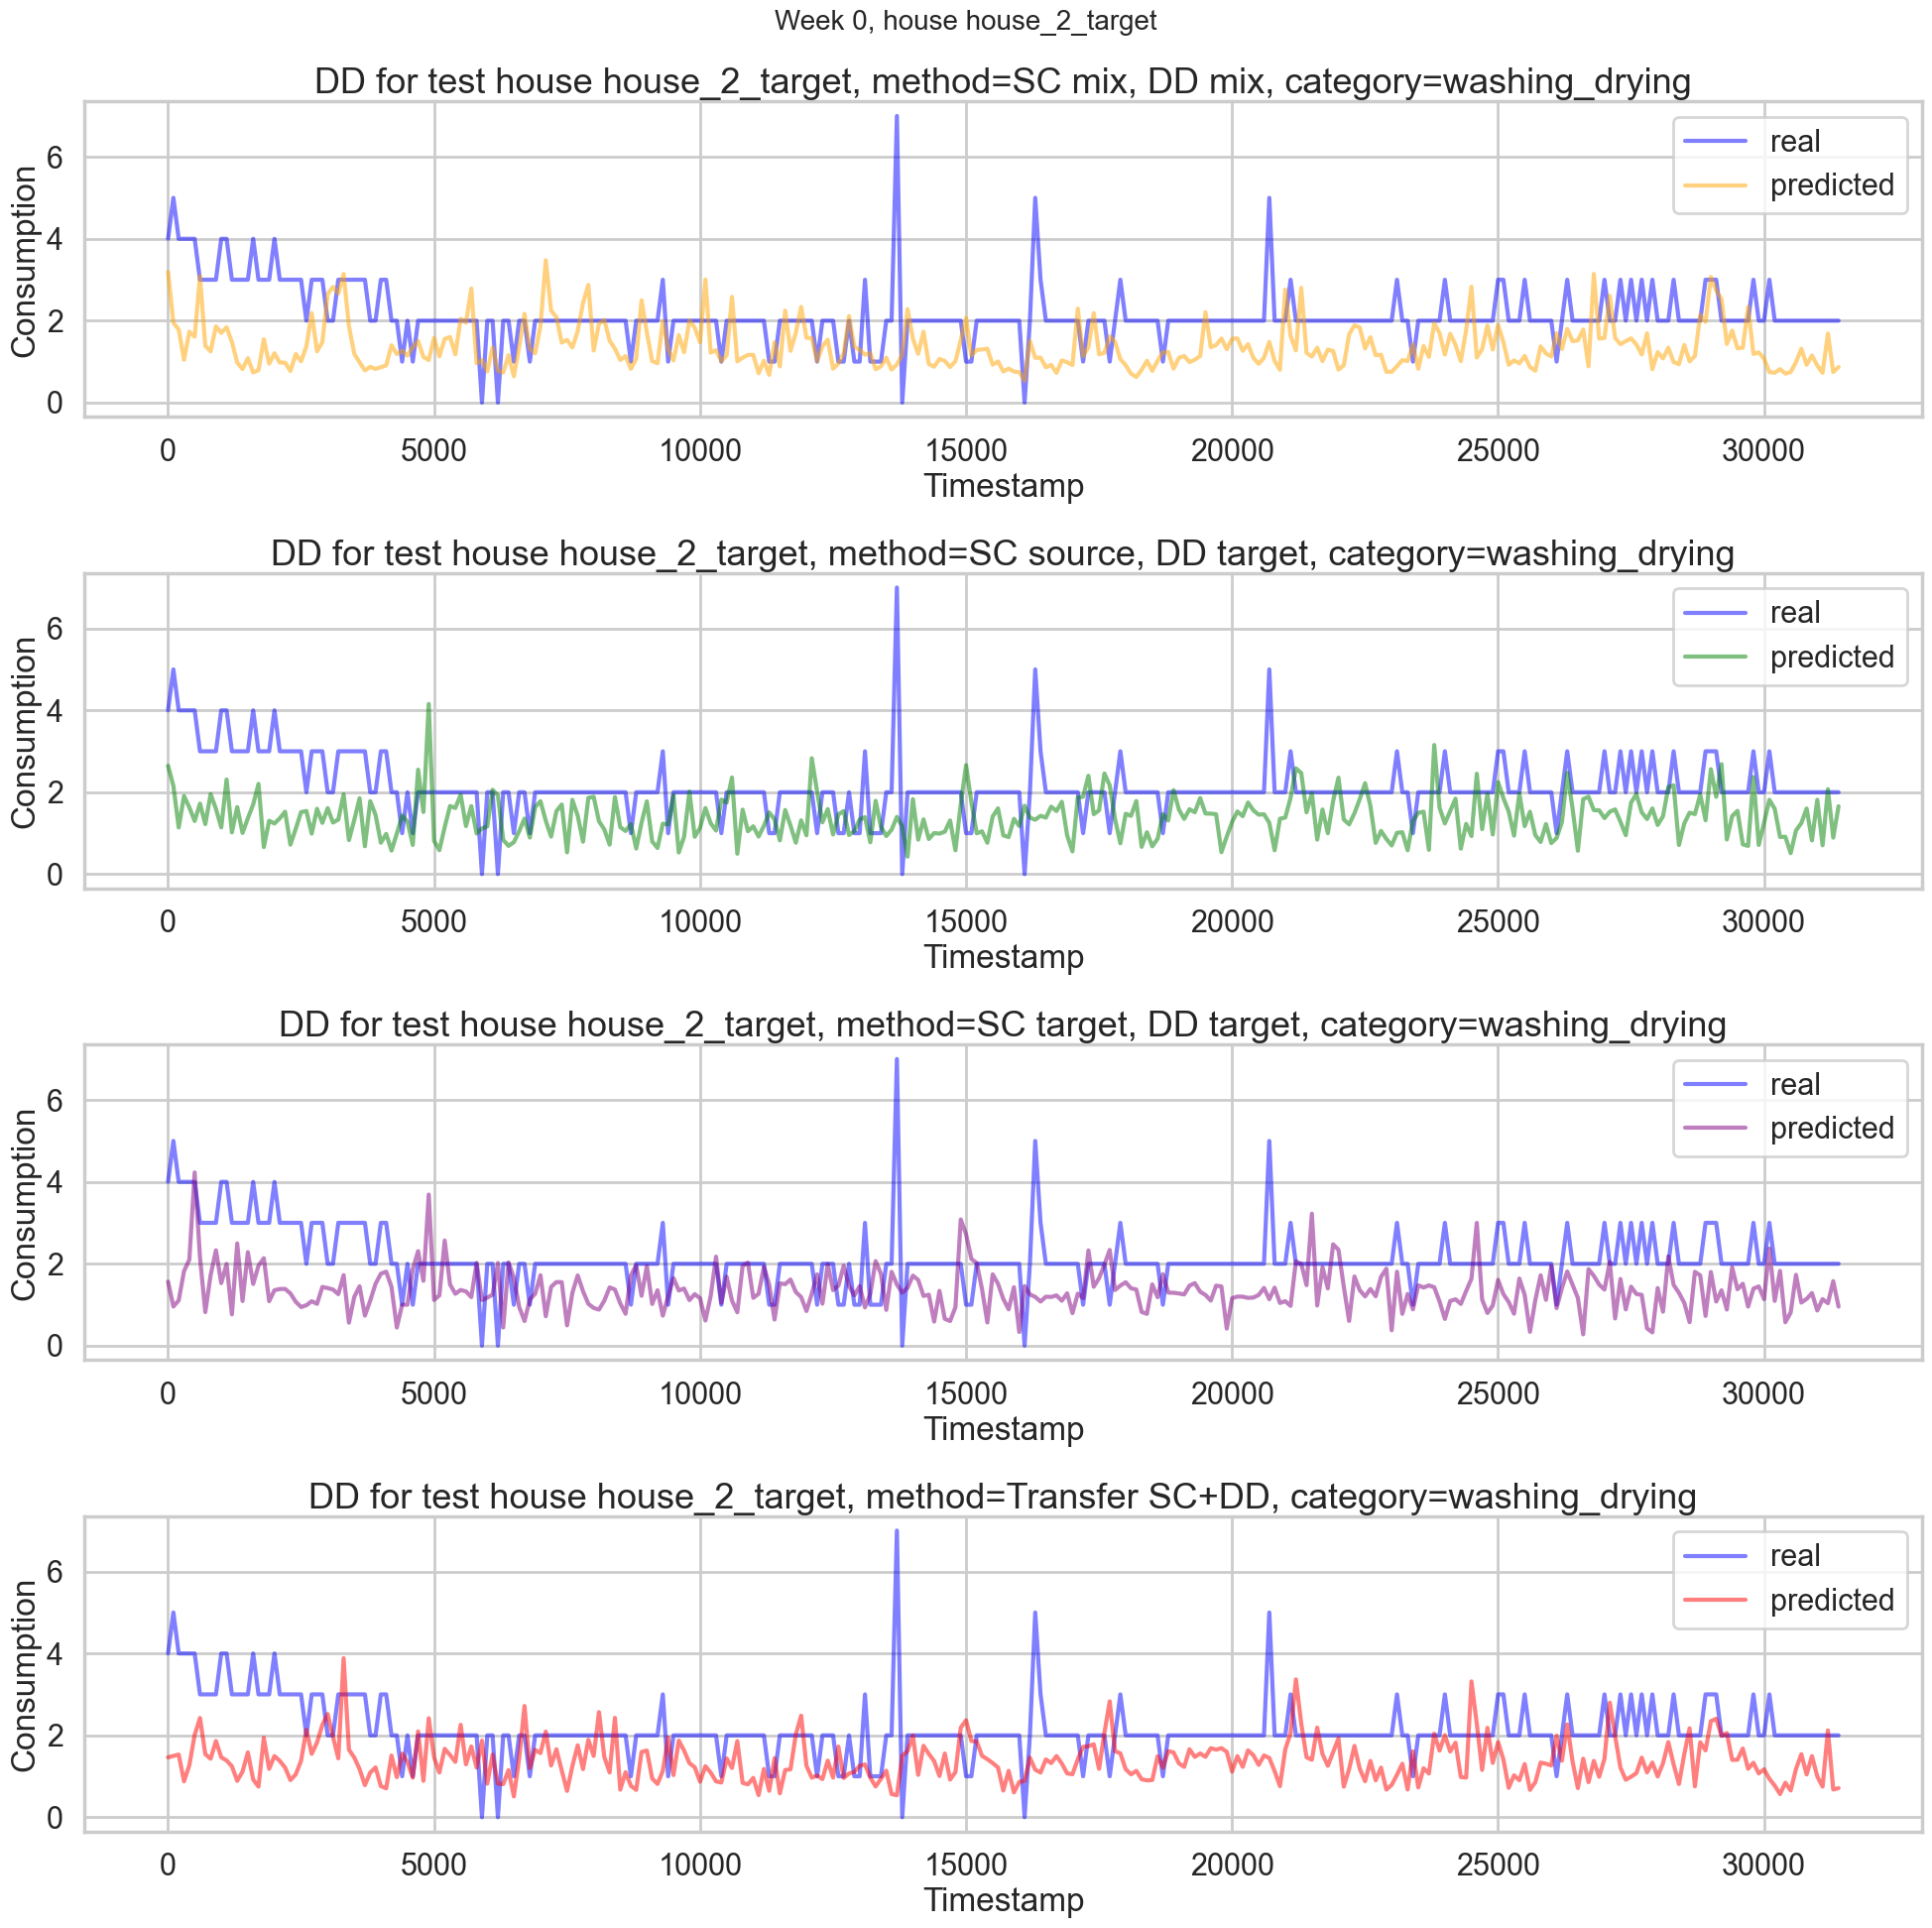

In [64]:
get_all_category_plots_by_method(test, nb_houses=2, nb_weeks=1, data_type='test')

### Plot noise

In [71]:
def get_noise(data, nb_houses, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    figs, axes = [], []
    for week in range(nb_weeks):
        pred_noise = dict()
        real_noise = dict()
        for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
            A = np.asarray(A)
            B = np.asarray(B)

            pred_noise[method] = data[week]['X_bar'].values
            real_noise[method] = data[week]['X_bar'].values
            for ind, cat in enumerate(appliance_categories):
                B_test_app = B[week][:,ind*n_components:(ind+1)*n_components]
                A_test_app = dsc.F_obj(x=test[week]['X'][cat].values, B=B_test_app,rp_gl=general_params['rp'])
                abt = np.dot(B_test_app, A_test_app)   
                pred_noise[method] = pred_noise[method] - abt
                real_noise[method] = real_noise[method] - data[week]['X'][cat].values
                
        for house in range(nb_houses):
            house_name = data[week]['X_bar'].columns[house]
            fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
            plt.suptitle('Week {}, {} house {}'.format(week, data_type, house_name), fontsize=20)
            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                
                
                ax[method_ind].plot([i*100 for i in range(len(real_noise[method]))], real_noise[method][:,house], c='blue', alpha=0.5)
                ax[method_ind].plot([i*100 for i in range(len(real_noise[method]))], pred_noise[method][:,house], c='red', alpha=0.5)
                ax[method_ind].set_xlabel('Timestamp', fontsize=24)
                ax[method_ind].set_ylabel('Consumption', fontsize=24)
                ax[method_ind].set_title('DD noise for {} house {}, method={}'.format(data_type, house_name, method), fontsize=26)
                ax[method_ind].legend(['real', 'predicted'])
            plt.tight_layout()
            figs.append(fig)
            axes.append(ax)

    with PdfPages('plots/noise_by_method_{}_{}.pdf'.format(data_type, data_source)) as pdf:
        for fig in figs:
            pdf.savefig(fig)



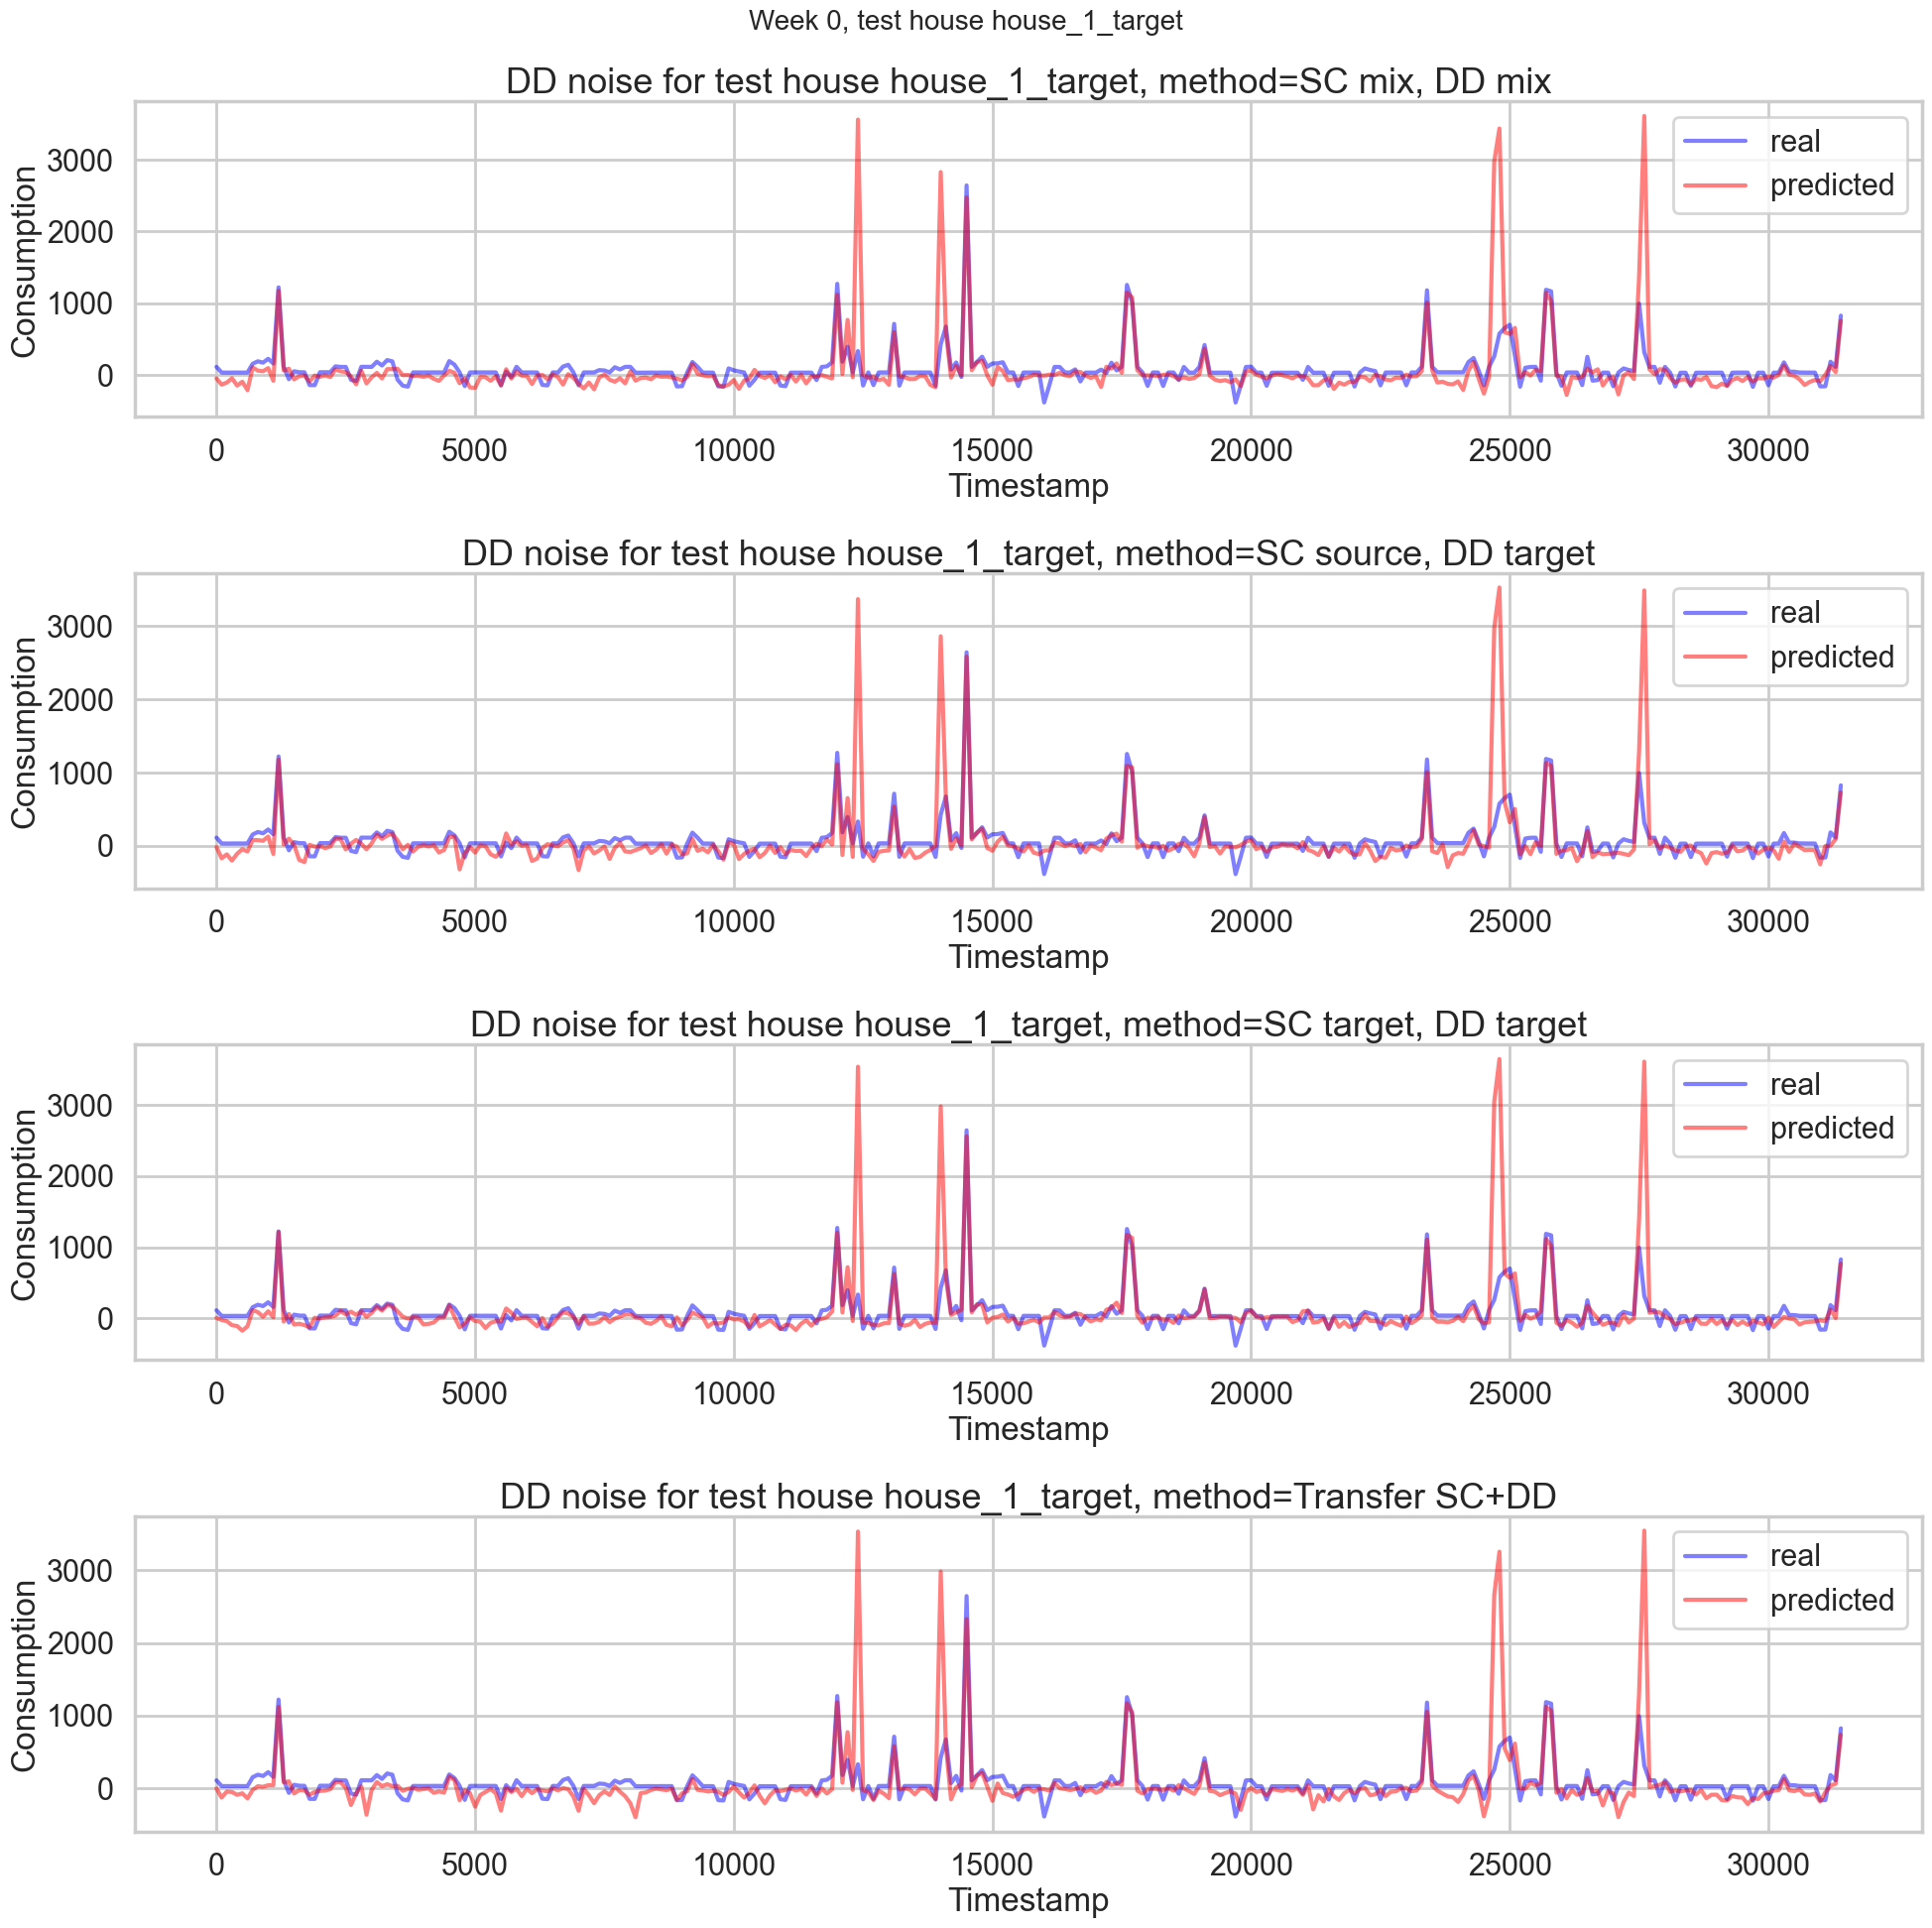

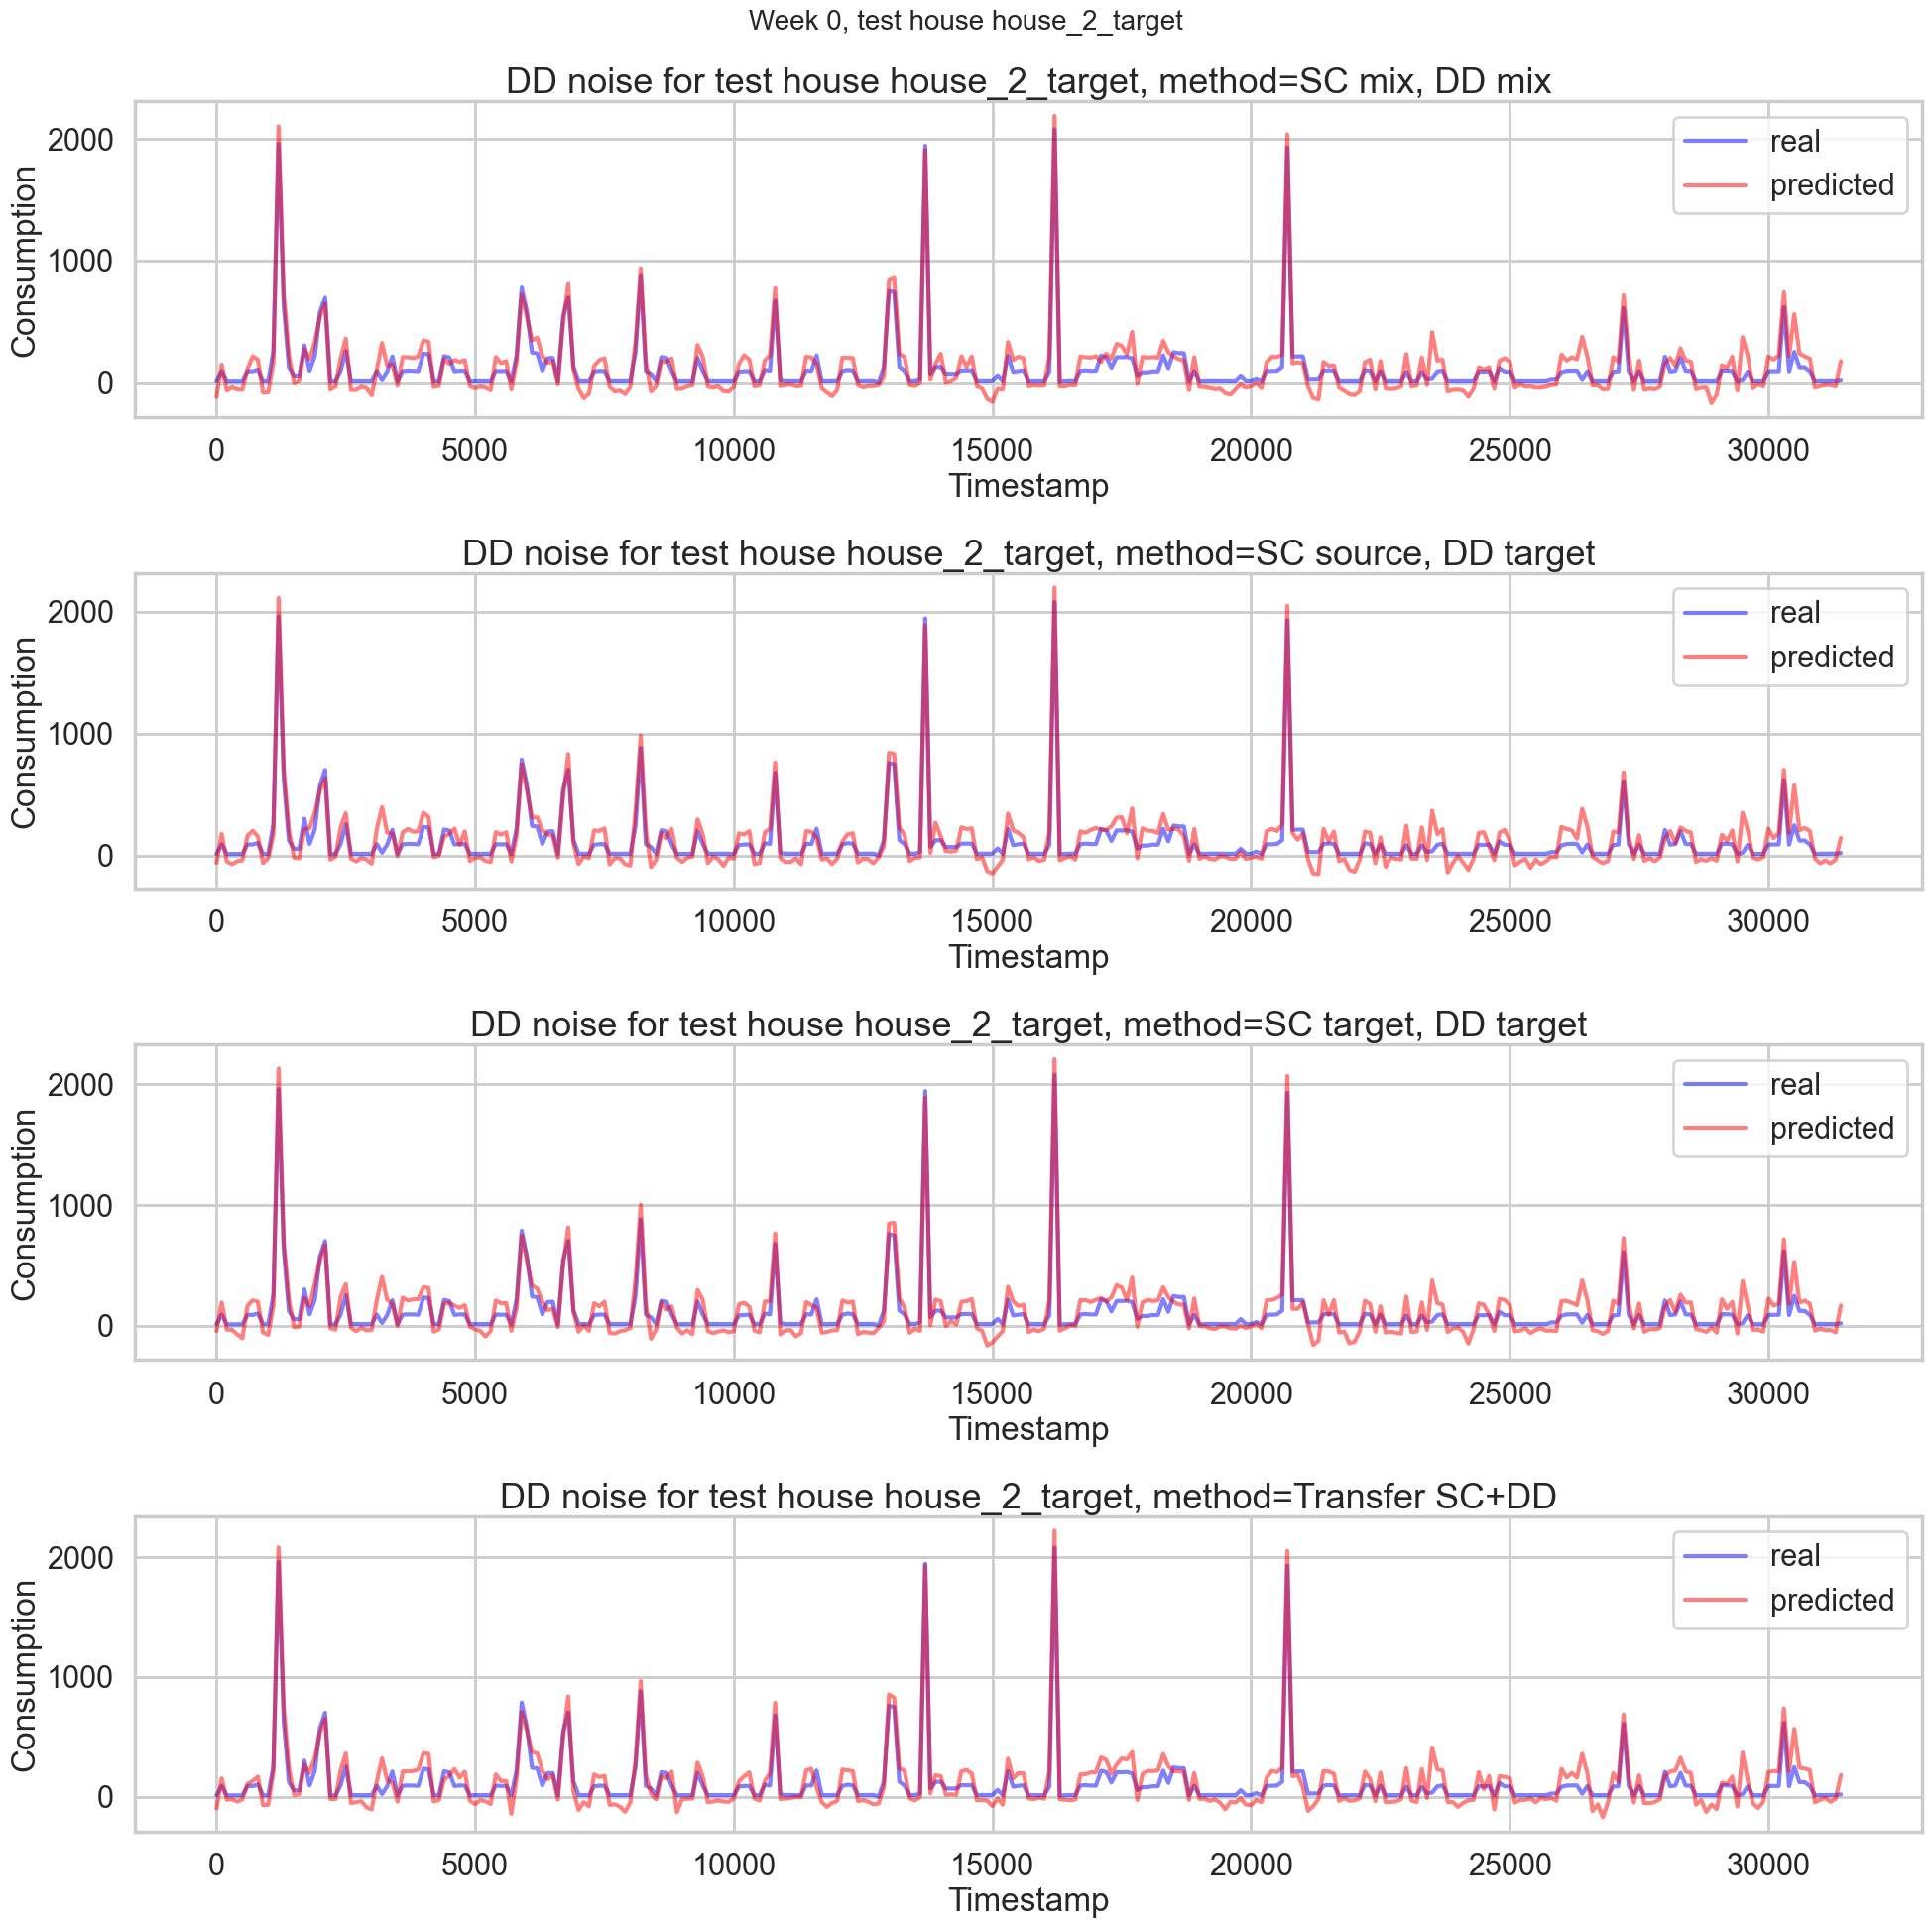

In [72]:
get_noise(test, nb_houses=2, nb_weeks=1, data_type='test')

### Extract Basis

In [37]:
def plot_bases(data, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    figs, axes = [], []
    for ind, cat in enumerate(appliance_categories):
        for week in range(nb_weeks):            
            fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
            plt.suptitle('Week {}'.format(week), fontsize=20)
            xt = data[week]['X'][appliance_categories[ind]]
            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):

                B_test_app = B[week][:,ind*n_components:(ind+1)*n_components].T

                ax[method_ind].imshow(B_test_app, cmap='gray')
                ax[method_ind].set_title('Learned Basis functions, method={}, category={}'.format(method, cat), fontsize=14)
            figs.append(fig)
            axes.append(ax)
        
        with PdfPages('plots/basis_functions_by_method_{}_{}.pdf'.format(data_type, data_source)) as pdf:
            for fig in figs:
                pdf.savefig(fig)

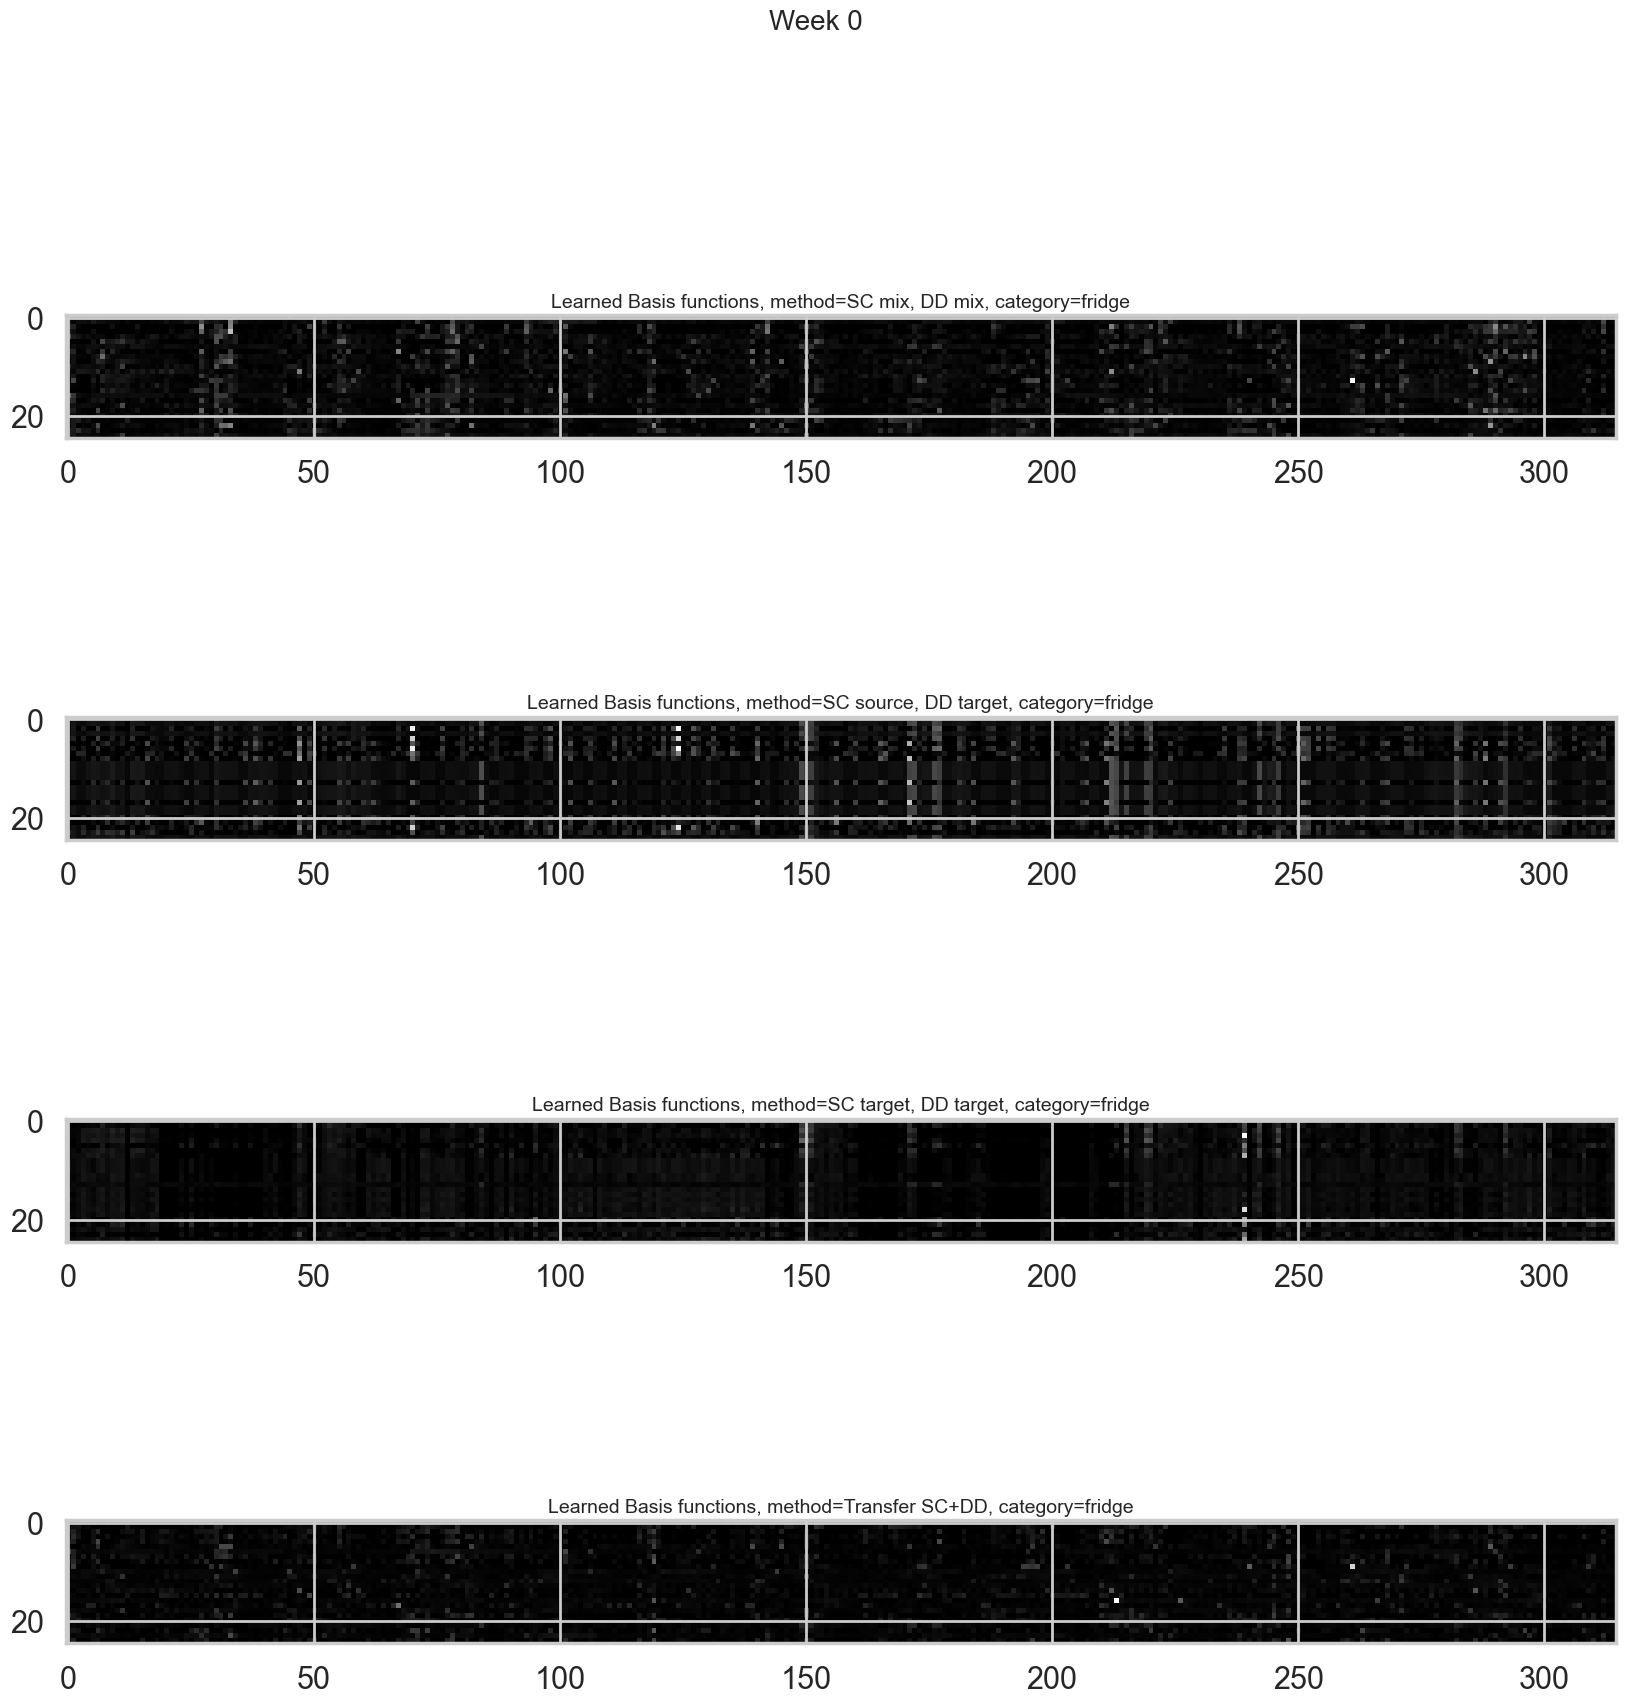

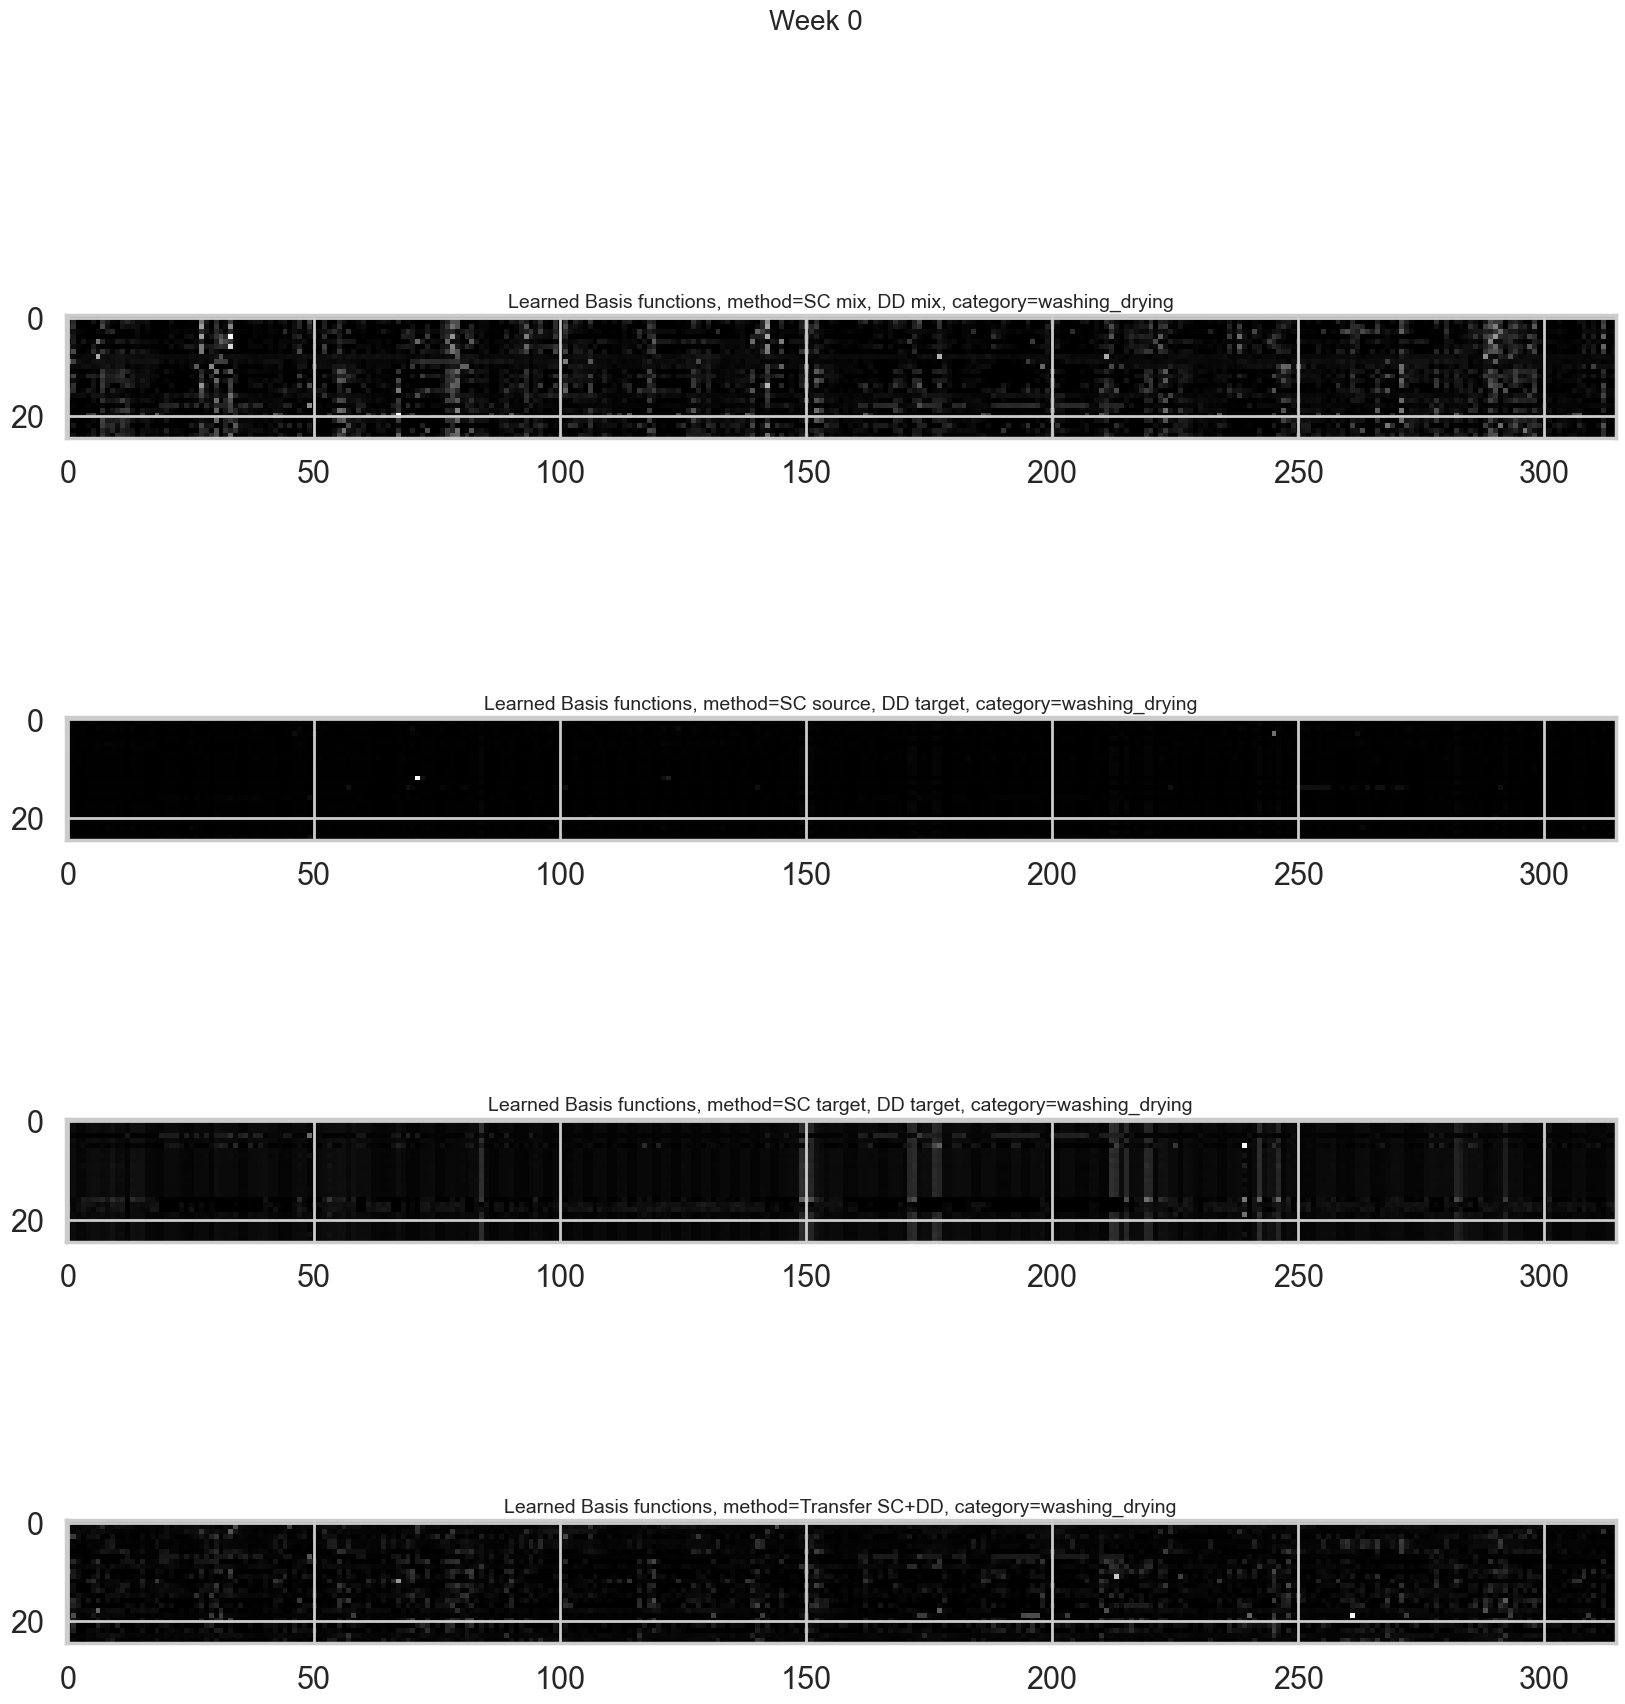

In [38]:
plot_bases(test, general_params['weeks_to_train'], data_type='test')